# Introduction

In this notebook we explore various clustering techniques for analyzing stocks and how clustering can be used to develop a pairs trading strategy. Pairs trading was first developed in the mid-1980s by analyst researchers at Morgan Stanely. The idea of pairs trading is that we should try and find two stocks which tend to move together (the technical term is that the stocks are co-integrated) and look for instances when the spread between the two stocks becomes significant. If we are reasonably sure that the spread between the two stocks is mean-reverting, i.e. that the spread between the stocks will eventually return to its long-term mean, than we can find profits by going long/short on the stock which is under/over-valued, respectively.

In practice, finding a successful pair-trading strategy is difficult. The first problem is finding a pair of stocks which are co-integrated. Given $n$ stocks there are a total of $n(n-1)/2$ pairs that we can consider. If $n$ is large, e.g. if we are considering all stocks in the S&P-500, then we have many pairs to check. We then run into the <a href="https://en.wikipedia.org/wiki/Multiple_comparisons_problem">multiple comparisons problem</a>, which says that if we perform too many comparison tests we are likely to find a spurious correlation simply due to pure random chance. In order to reduce this problem, we can try and group our stocks into clusters, e.g. grouping stocks by their industry sector, both to reduce the number of pairs we need to check and because we expect that stocks in the same sector are more likely to be co-integrated. This is where machine learning comes into play: we can potentially use methods from unsupervised learning to group stocks into clusters. By constructing the right set of features and having access to enough data we can potentially find pair-trading opportunities which were not previously known about.

An additional problem is determining which pair-trading strategies are actually profitable. In order for a pair-trading strategy to be profitable we need our strategy to actually generate enough useful signals. That is, if we find two stocks which are co-integrated, but the spread never becomes statistically significant than we can never actually short/long any stocks. Moreover, if we only get a tradeable signal once a year than it may not be worth it to use this strategy. For this reason, we only want to consider pairs which consistently generate tradeable signals. There are other subtleties, such as including the cost of transaction fees and possible market impact, which we will consider in the future.

The layout of this notebook is as follows:

* In section **Dependencies and Definitions** we import packages and define functions which will be used in the rest of this notebook.

* In section **Process Data** we download and process stock data. We scrape wikipedia to get the list of the stocks in the S&P-500 and download their price data from Yahoo Finance. We split our data into train, validation, and test sets and also split the stocks by industry according to the Global Industry Classification Standard (GICS). 

* Section **Clustering** contains our code for clustering stocks using four different algorithms: K-means, hierarchical, Affinity, and Optics. We first perform clustering using just the stock's mean and volatility. Performing clustering using two variables is useful since we can easily plot the clusters using 2d plots. We then perform clustering using four features: mean, volatility, skew, and kurtosis. We expect that including skew and kurtosis will give us a better picture of stocks actually behave since stock returns are not Gaussian distributed. Note that we perform clustering for each industry sector individually, we are not performing a clustering analysis on all the stocks at once. For both subsections the clustering is only performed using returns from the *training set*.

* Finally, in Section **Pair Trading** we take our previous stock clusters and test each pair to see if they are co-integrated. To avoid the multi-comparisons problem we will only keep stocks with a Hurst exponent < 0.5. We will also only keep stocks with a short enough half-life and which generate enough signals in a year. This filtering procedure is first carried using just the training split of the dataset and then repeated using the validation split. After performing this filtering procedure, we test the performance of our strategy on the test set.

# Dependencies and Definitions

In [61]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
from sklearn.cluster import OPTICS
import pandas_datareader as dr

#Import Model Packages 
from sklearn import cluster, covariance, manifold, metrics
from sklearn.cluster import KMeans, AgglomerativeClustering,AffinityPropagation, DBSCAN
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_mutual_info_score
from scipy.cluster.hierarchy import dendrogram, linkage, ward

from collections import Counter


#Other Helper Packages and functions
import matplotlib.ticker as ticker
from itertools import cycle
import statsmodels.api as sm
import yfinance as yf

In [3]:
def download_stocks(tickers,start='2014-01-01',end='2018-01-01'):
    """
    Downloads equity data from Yahoo Finance.
    
    Inputs:
    -------
    - tickers (List[str]): List of strings containing the tickers.
    - start (str): Start date for stock data.
    - end (str): End date for stock data.
    
    Output:
    - Pandas dataframe containing full stock data.
    """
    return yf.download(tickers, start = start, end = end)

def remove_null(df):
    """
    Removes null values from Pandas dataframe.
    
    Inputs:
    -------
    - df (Pandas DataFrame): Contains stock prices.
    
    Output:
    - Pandas Dataframe with all stocks with null values removed.
    """
    df = df.dropna(axis=1)
    return df

def winsorize(df,q=.025):
    """
    Clip financial data to remove outliers.
    
    Inputs:
    -------
    - df (Pandas DataFrame): Contains stock data with null values removed.
    - q (float): quantile at which to clip prices. Clip stocks at q-th and (1-q)-th quantile.
    
    Outputs:
    - Pandas dataframe with large outliers clipped to specified quantile.
    
    """
    clipped = df.clip(lower=df.quantile(q=q),
                   upper=df.quantile(q=1-q),
                   axis=1)
    return clipped

def df_scaler(df):
    """
    Produces a StandardScaler object which sets input df to have zero mean and unit variance.
    
    Inputs:
    ------
    - df (Pandas Dataframe): Dataframe with unnormalized data.
    
    Outputs:
    --------
    - scaler: Sklearn StandardScaler which can be used to transform other dataframes.
    """
    scaler = StandardScaler().fit(df)
    return scaler

def train_test_split(df,percentage = .8):
    """
    Splits time-series data into train and test-sets.
    
    Inputs:
    -------
    - df (Pandas DataFrame): Dataframe containing time-series data.
    - percentage (float): Fraction of data to keep in the train set. Rest is put in test set.
    
    Outputs:
    - train_set, test_set (Tuple(DataFrames)): Train and test datasets.
    """
    
    # Use int to round len(df)*percentage to the smallest, nearest integer.
    train_size = int(len(df)*percentage) 
    train_set = df[:train_size]
    test_set = df[train_size:]

    return train_set, test_set

def normalize_data(df_train,df_test):
    scaler = StandardScaler().fit(df_train)

    train = pd.DataFrame(scaler.transform(df_train),
                         columns = df_train.columns,
                         index = df_train.index)

    test = pd.DataFrame(scaler.transform(df_test),
                        columns = df_test.columns,
                        index = df_test.index)

    return train, test

# Download Data

We start by scraping Wikipedia to find the current list of stocks on the S&P-500

In [4]:
# load dataset
#scraping wikipedia to fetch S&P 500 stock list
snp500url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
SP_stocks = pd.read_html(snp500url)
SP_tickers = SP_stocks[0]['Symbol'].to_list()

We then download stock prices from 2010-01-01 to 2018-01-01 (this is the default end date in download_stocks). For simplicity we drop all stocks that have any missing values, although we could use forward-fill (or some other more advanced method) to fill in the missing values.

Below we split our dataset into train, validation and test sets. We perform a 60%-20%-20% sets between the three sets. We split the data sequentially, as opposed to randomly, to avoid any data leakage.

In [9]:
SP_data = download_stocks(SP_tickers,start='2010-01-01')['Adj Close'].dropna(axis=1)
SP_data.index = pd.to_datetime(SP_data.index)

# total_time = number of rows in our dataset.
total_time = SP_data.shape[0]
# val_begin = index corresponding to first element of validation set.
val_begin = int(total_time*.6)
# test_begin = index corresponding to first element of test set
test_begin = val_begin + int(total_time*.2)

# df is a dictionary with keys 'train','valid', and 'test' whose values are the corresponding splits of the dataset.
df = {}

df['train'] = SP_data[:val_begin]
df['valid'] = SP_data[val_begin:test_begin]
df['test'] = SP_data[test_begin:]

# df_ret is the almost the same as df, except each dataframe contains the stock returns instead of their prices.
df_ret = {}
for key in df:
    df_ret[key] = df[key].pct_change().dropna()

[*********************100%***********************]  503 of 503 completed

14 Failed downloads:
- FOXA: Data doesn't exist for startDate = 1262322000, endDate = 1514782800
- GEHC: Data doesn't exist for startDate = 1262322000, endDate = 1514782800
- CTVA: Data doesn't exist for startDate = 1262322000, endDate = 1514782800
- DOW: Data doesn't exist for startDate = 1262322000, endDate = 1514782800
- MRNA: Data doesn't exist for startDate = 1262322000, endDate = 1514782800
- OTIS: Data doesn't exist for startDate = 1262322000, endDate = 1514782800
- BF.B: No data found for this date range, symbol may be delisted
- CDAY: Data doesn't exist for startDate = 1262322000, endDate = 1514782800
- CEG: Data doesn't exist for startDate = 1262322000, endDate = 1514782800
- CARR: Data doesn't exist for startDate = 1262322000, endDate = 1514782800
- BRK.B: No timezone found, symbol may be delisted
- VICI: Data doesn't exist for startDate = 1262322000, endDate = 1514782800
- FOX: Data doesn't exist for 

At this point, we now want to split our datasets by their industrial sector. To do this we define df_sectors, which will be a dictionary of dictionaries. For example, df_sectors['train'] will be a dictionary where each key corresponds to an industrial sector, e.g. "Health Care", and the corresponding value is a Pandas DataFrame for all stocks in the healthcare sector. Similarly, df_sectors['valid'] and df_sector['test'] will also be dictionaries with (key,value) pairs of industrial sectors and the corresponding data of stock returns in that sector.

In [11]:
sectors = SP_stocks[0]['GICS Sector'].unique()

df_sectors = {}

for key in df:
    df_sectors[key] = {}
    
    for sector in sectors:
        
        # ticker_sector is a list of strings containing all tickers in a given GICS sector.
        ticker_sector = SP_stocks[0][SP_stocks[0]['GICS Sector']==sector]['Symbol'].to_list()
        
        # We previously removed stocks which had any missing values. To avoid any KeyValue errors we
        # restrict ticker_sector to only contain stocks in the df_ret[key] dataframe..
        ticker_sector = list(set(ticker_sector) & set(df_ret[key].columns))
        df_sectors[key][sector] = df_ret[key].loc[:,ticker_sector]

Next, we reduce the dimensionality of our data to just four by computing the mean, volatility, skew, and kurtosis of the stock returns. df_aggs is again a dictionary of dictionaries. df_aggs has keys 'train', 'valid', 'test' for the three splits of our dataframe. Each key of df_aggs['train'] again corresponds to an industrial sector and the corresponding value is a Pandas DataFrame for the mean, volatility, skew, and kurtosis of all the stocks in that sector.

In [12]:
df_aggs = {}

for key in df_sectors:
    df_aggs[key] = {}
    for sector in sectors:
        df_aggs[key][sector] = df_sectors[key][sector].mean()
        df_aggs[key][sector] = pd.DataFrame(df_aggs[key][sector])
        df_aggs[key][sector].columns = ['Mean']
        df_aggs[key][sector]['Volatility'] =  df_sectors[key][sector].std()
        df_aggs[key][sector]['Skew'] = df_sectors[key][sector].skew()
        df_aggs[key][sector]['Kurtosis'] = df_sectors[key][sector].kurtosis()

# Clustering

In this section we consider four different clustering algorithms, K-means, hierarchical, affinity, and Optics. In the first subsection we will cluster stocks by their 

## Features = [Mean, Volatility]

### K-means

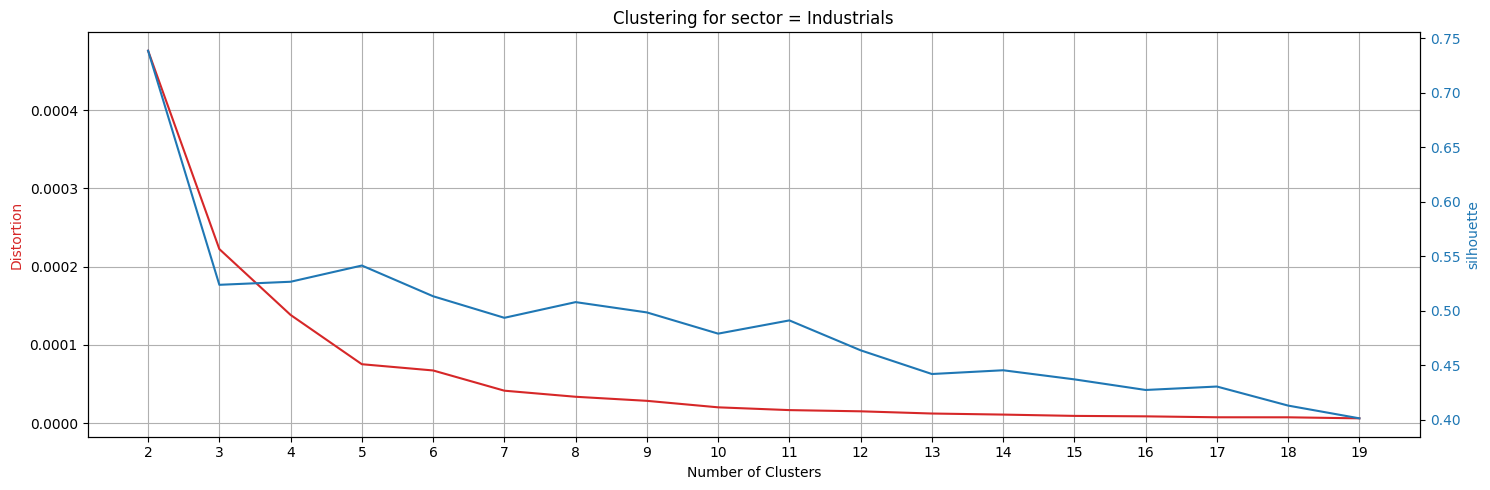

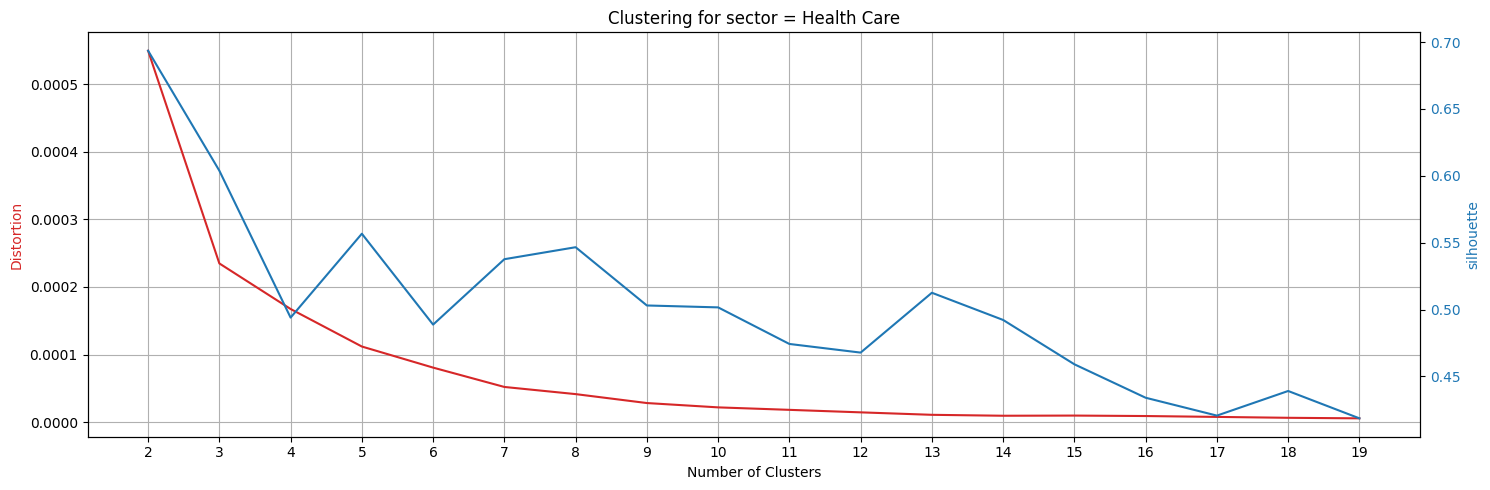

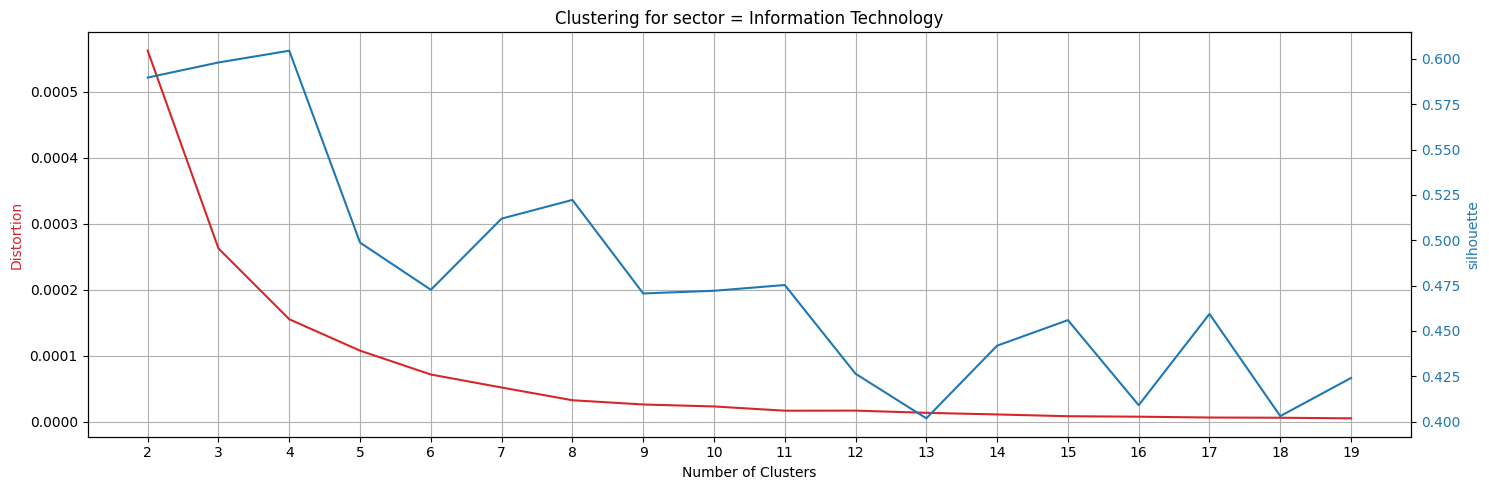

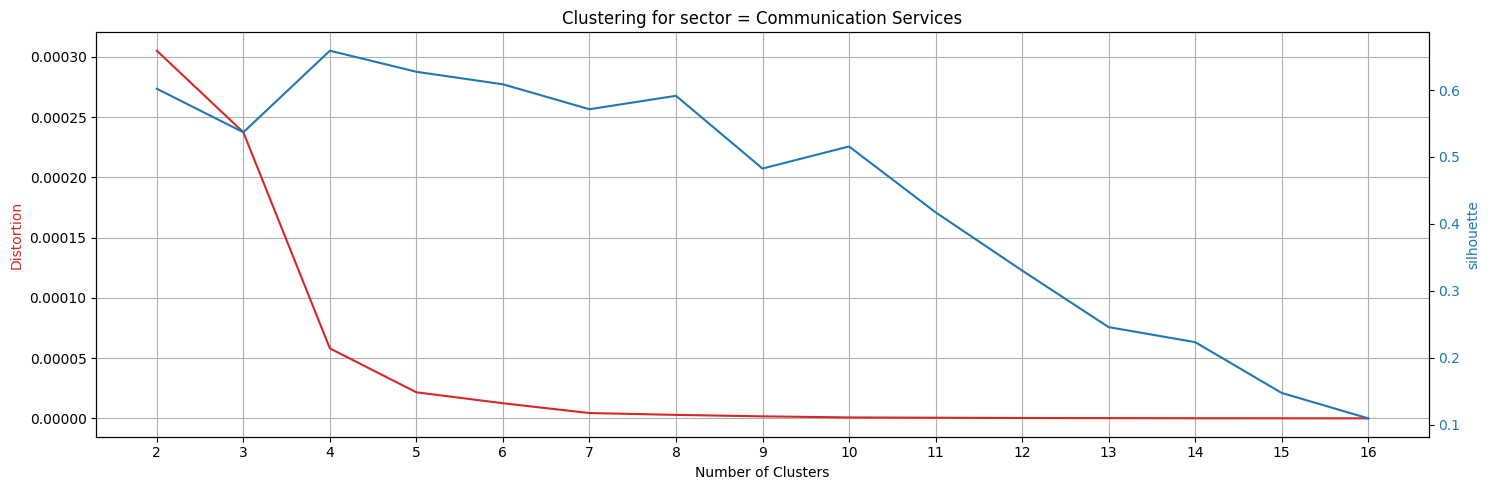

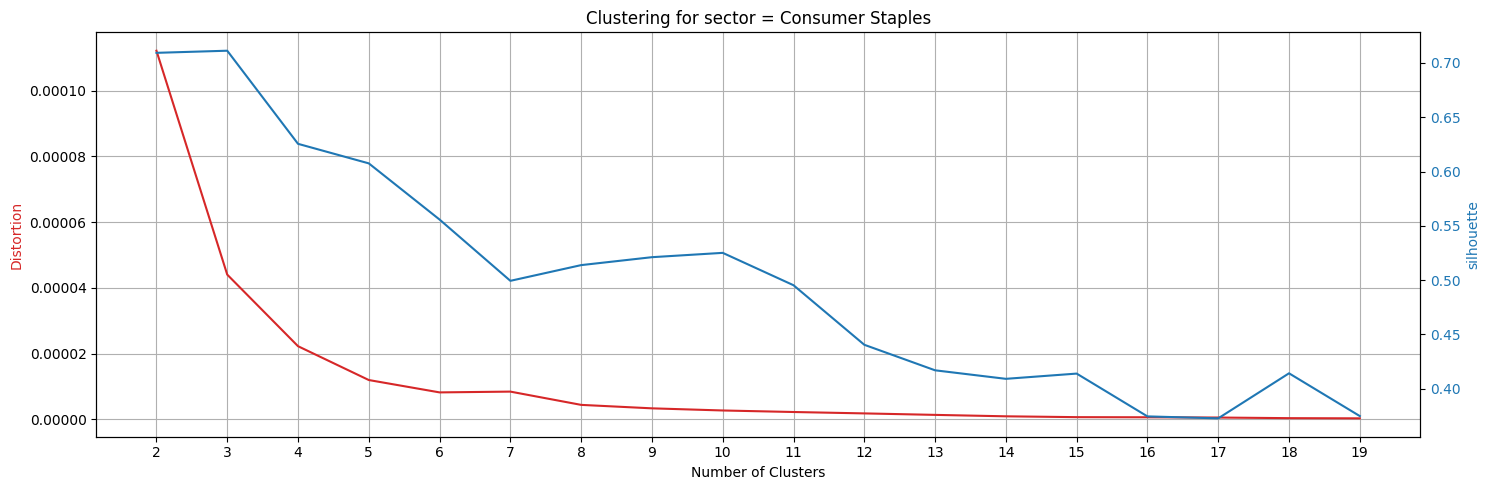

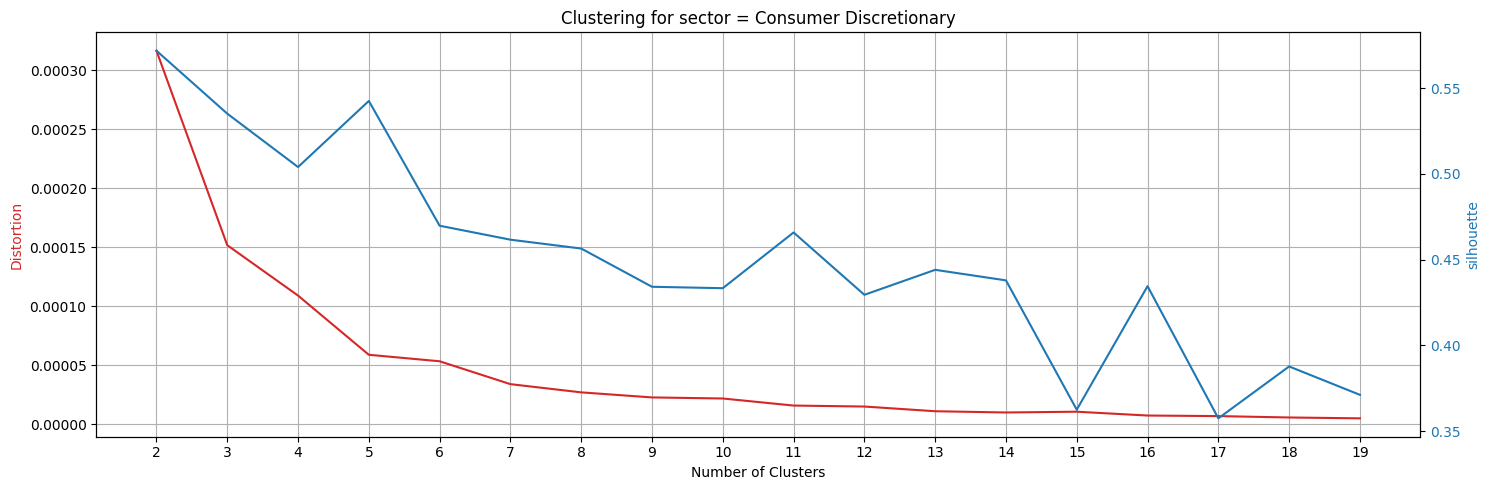

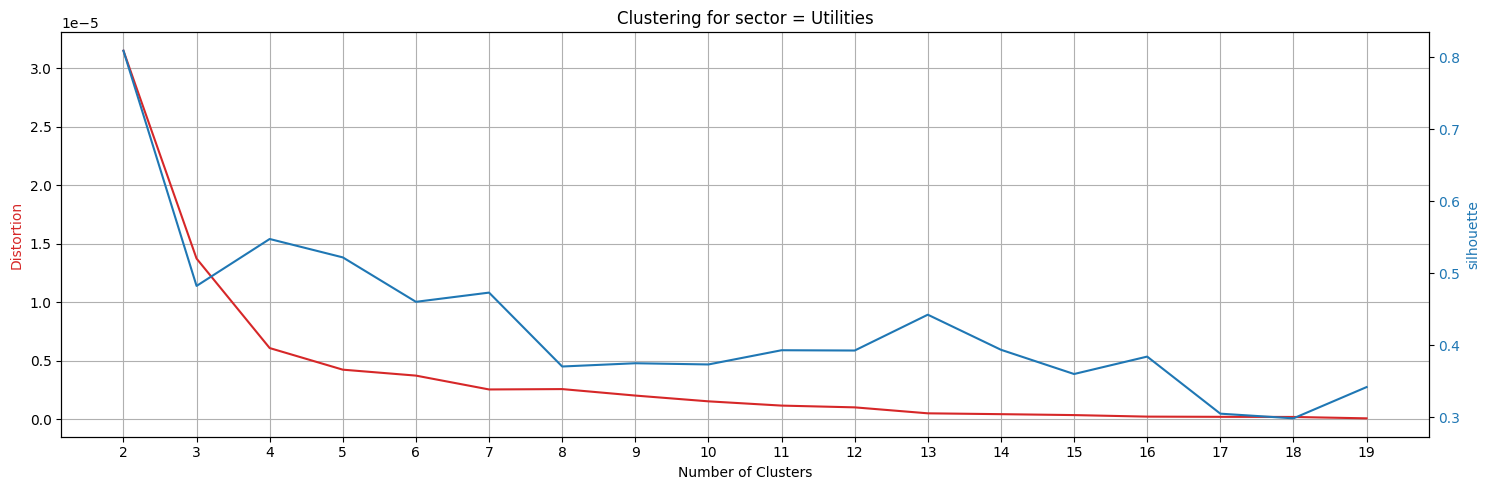

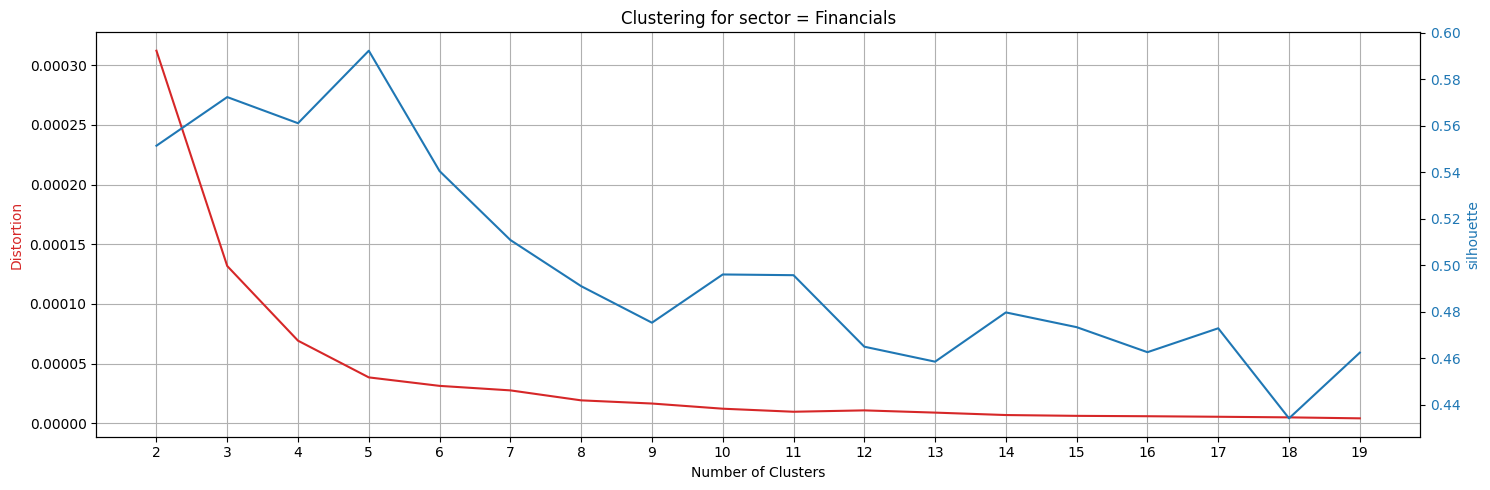

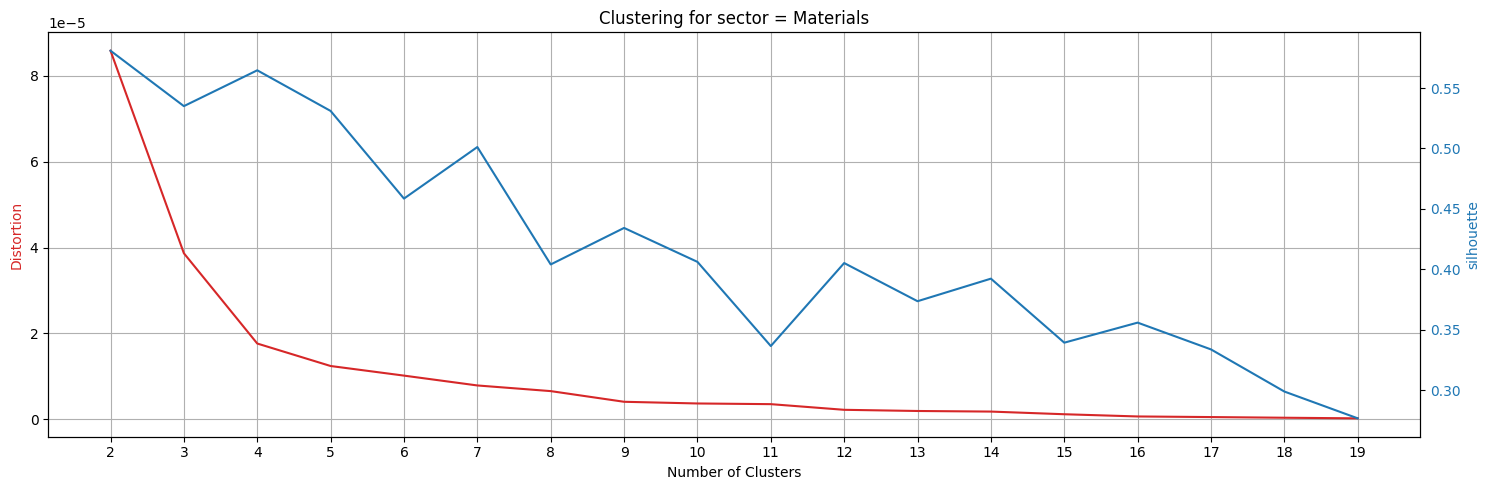

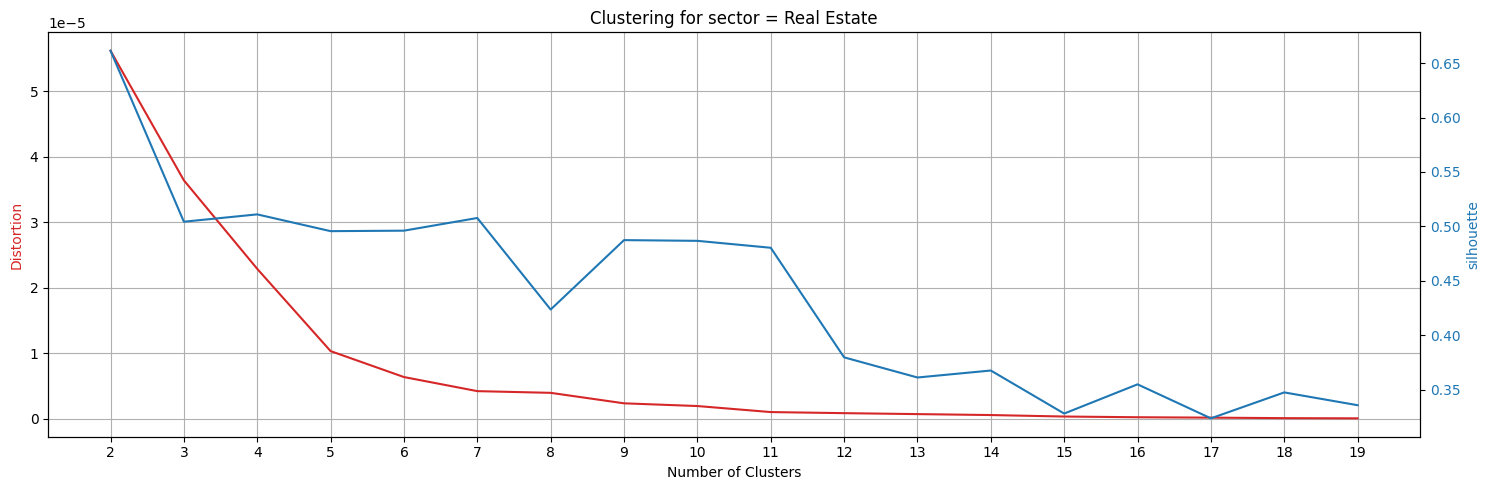

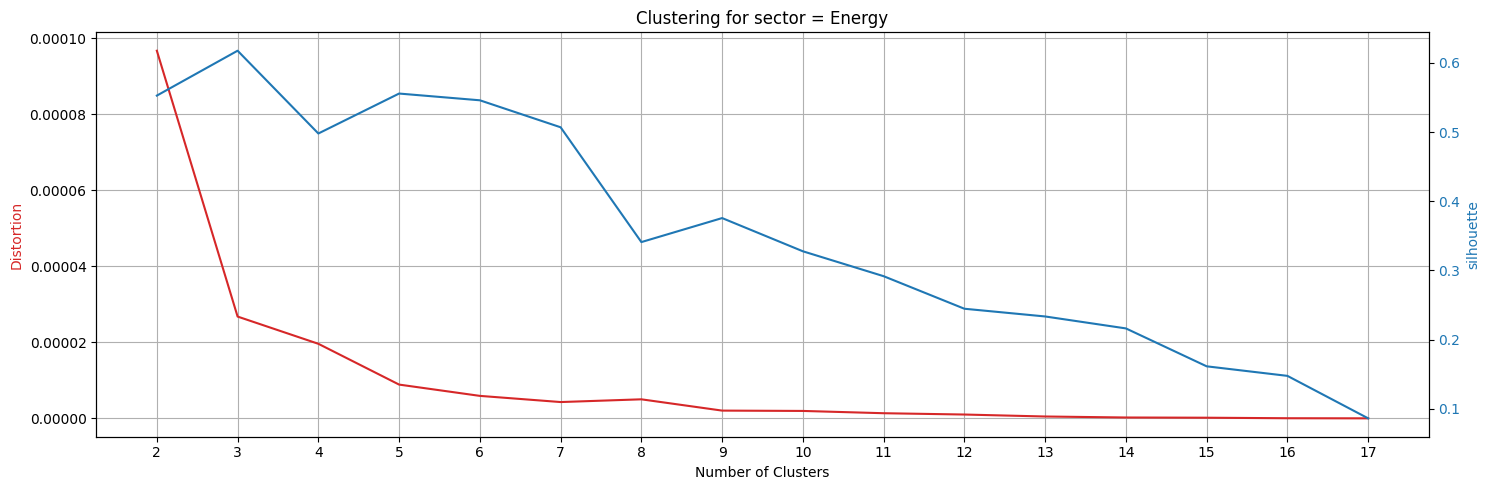

In [80]:
for sector in sectors:
    
    fig, ax1 = plt.subplots(figsize=(15, 5))
    
    color = 'tab:red'
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Distortion',color=color)
    plt.grid(True)
    plt.title(f'Clustering for sector = {sector}')
    distorsions = []
    max_loop=20
    silhouette_score = []
    for k in range(2, max_loop):
        try:
            kmeans = KMeans(n_clusters=k,n_init='auto')
            kmeans.fit(df_aggs['train'][sector].loc[:,['Mean','Volatility']])
            distorsions.append(kmeans.inertia_)
            silhouette_score.append(metrics.silhouette_score(df_aggs['train'][sector].loc[:,['Mean','Volatility']],
                                                             kmeans.labels_,
                                                             random_state=10))
        except:
            max_loop=k
            break

    distorsions = distorsions[:len(silhouette_score)]
    ax1.plot(range(2, max_loop), distorsions,color=color)
    ax2 = ax1.twinx()
    
    color='tab:blue'
    ax2.set_ylabel('silhouette',color=color)
    ax2.plot(range(2, max_loop), silhouette_score,color=color)
    ax2.tick_params(axis='y',labelcolor=color)
    
    fig.tight_layout()
    plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.show()


In [93]:
k_means.labels_

array([3, 0, 3, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 2, 3, 3, 2, 0, 2,
       2, 3, 2, 3, 4, 3, 0, 4, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 2, 3, 3, 0, 3, 0, 3, 2, 0, 3, 0, 3, 3, 3, 3, 3, 3, 0],
      dtype=int32)

In [92]:
target_labels

array([3, 0, 3, 0, 2, 1, 0, 0, 0, 0, 0, 2, 0, 3, 0, 0, 2, 3, 3, 2, 0, 2,
       2, 3, 2, 3, 4, 3, 0, 4, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 0,
       3, 3, 3, 2, 3, 3, 0, 3, 0, 3, 2, 0, 3, 0, 3, 3, 3, 3, 3, 3, 0],
      dtype=int32)

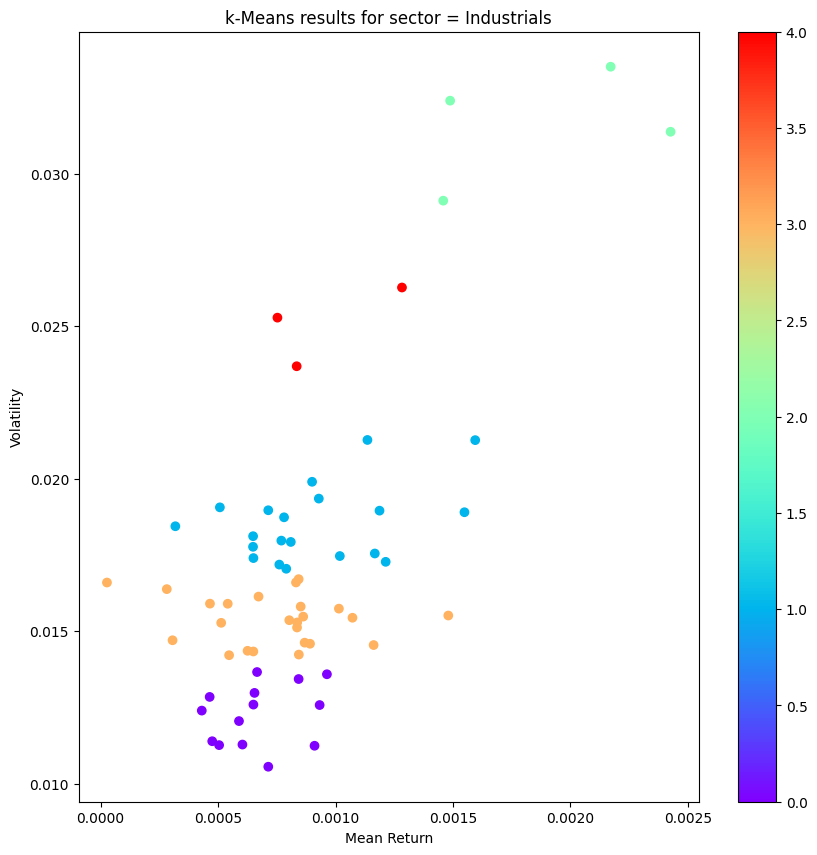

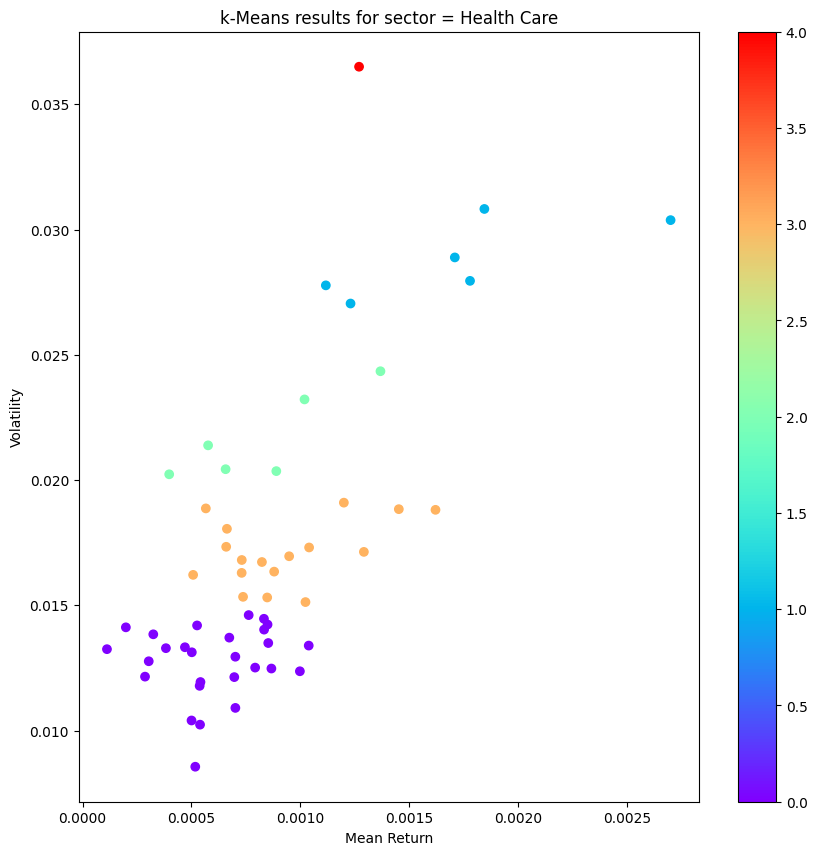

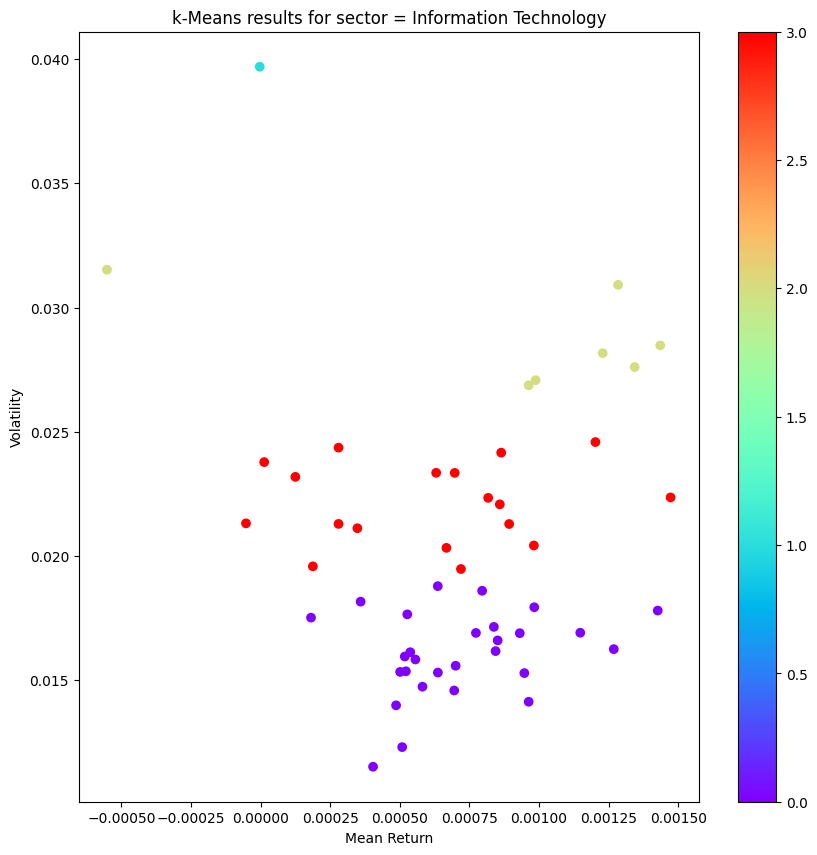

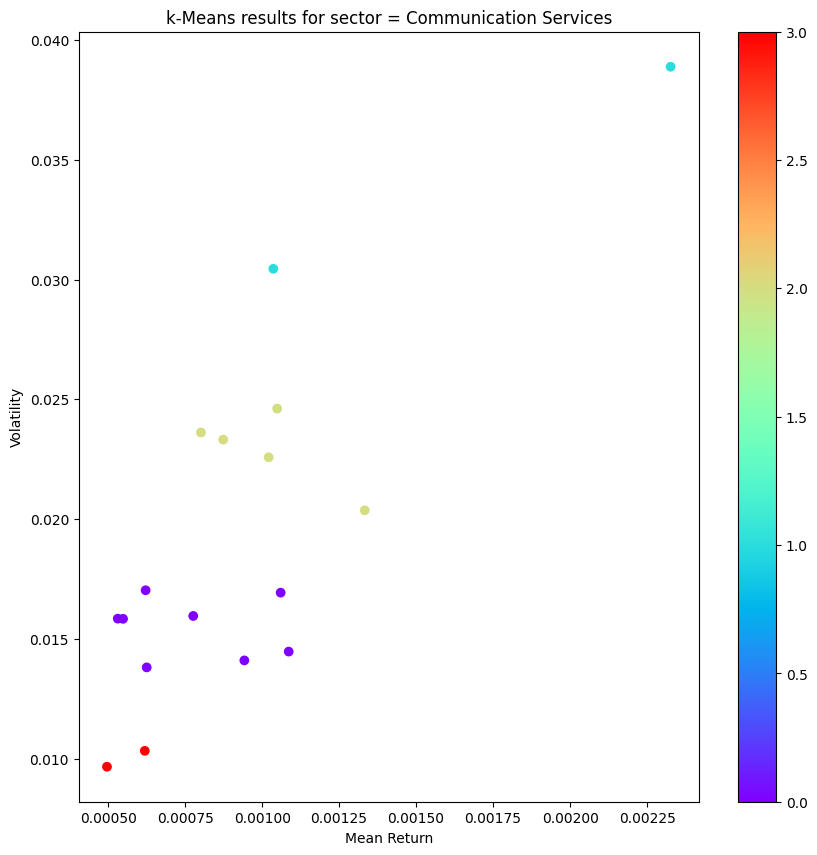

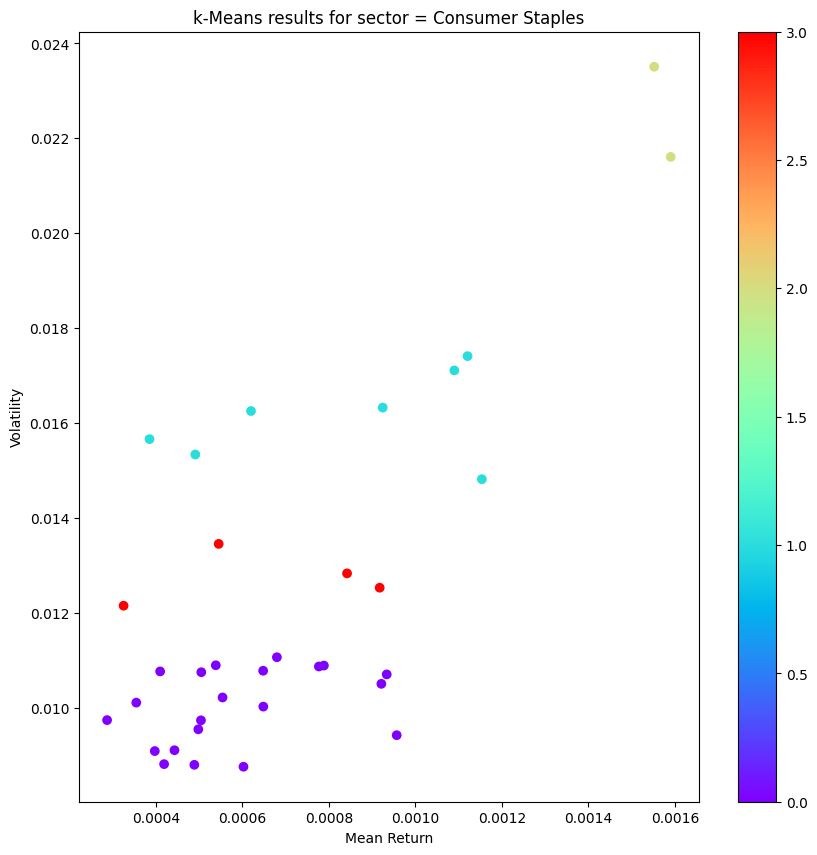

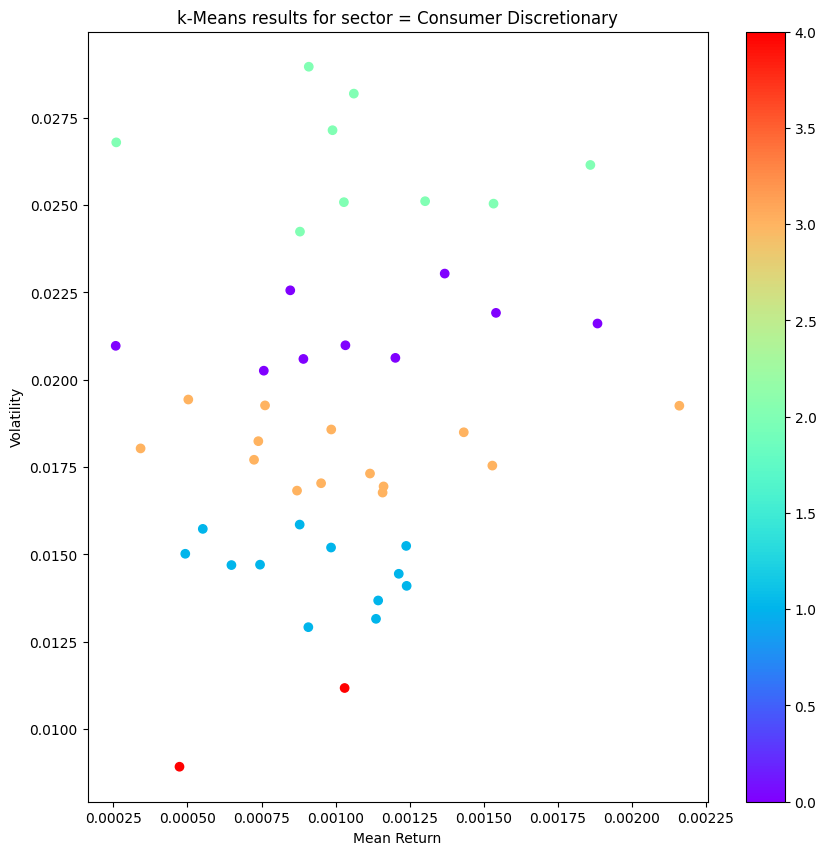

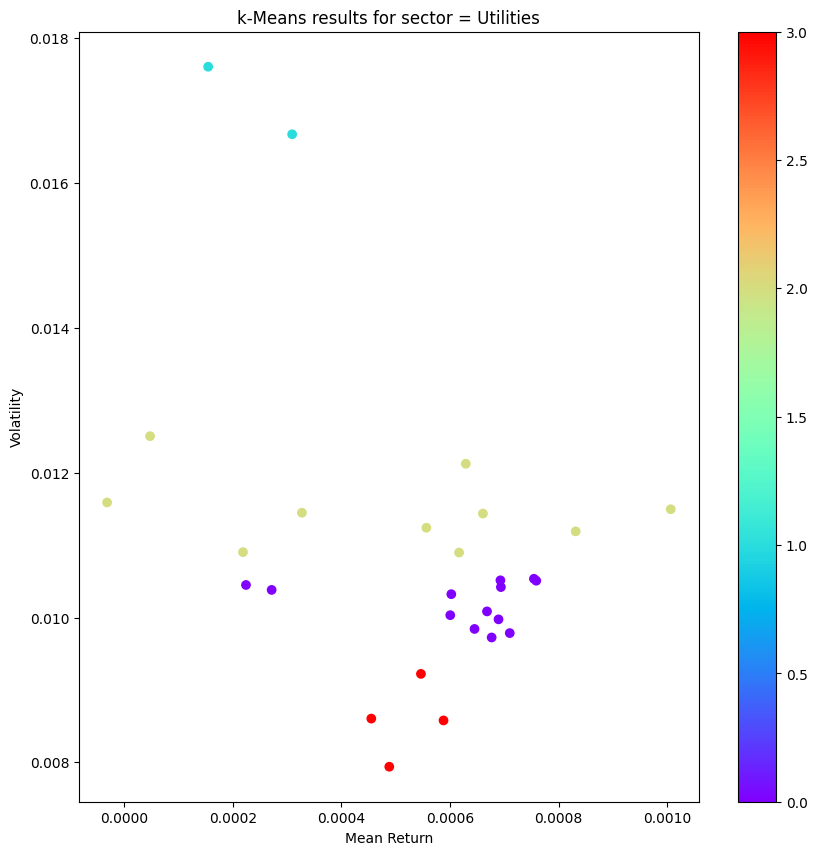

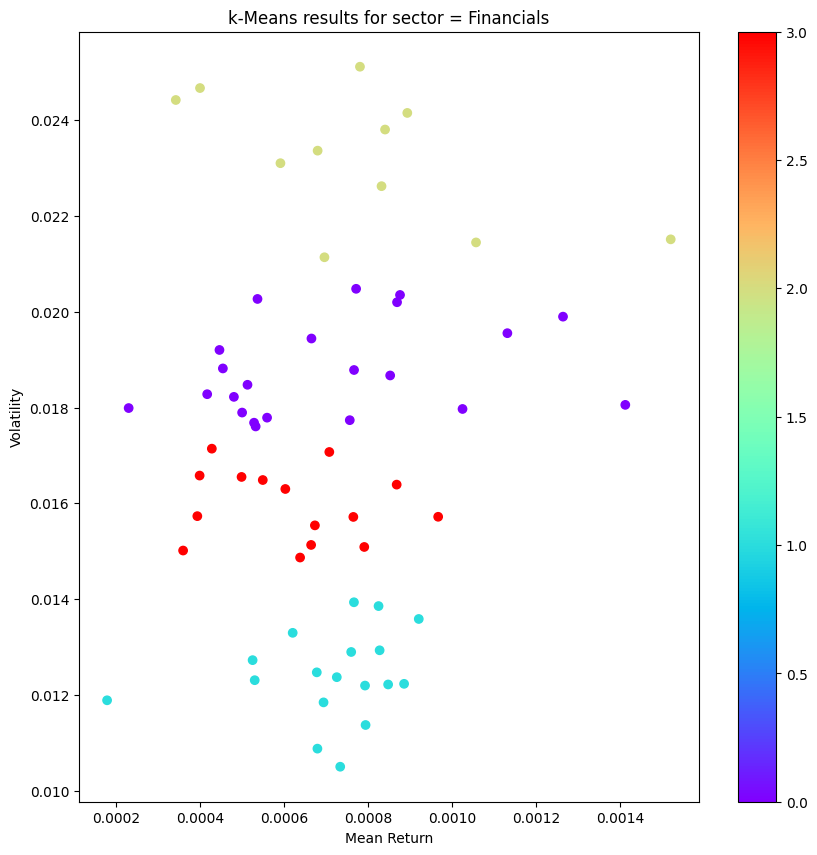

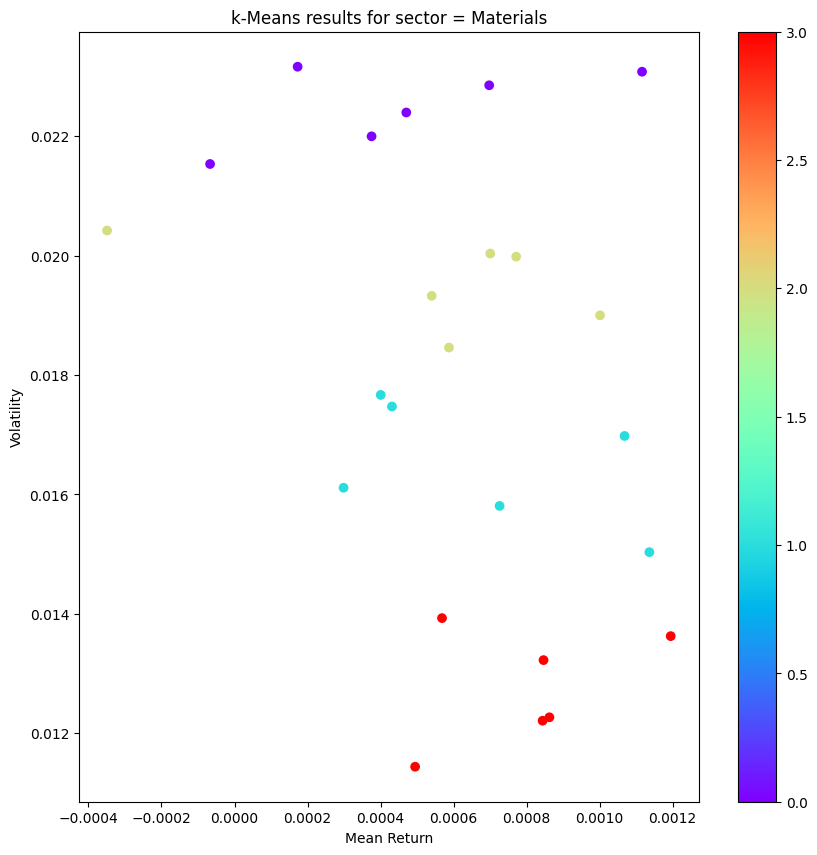

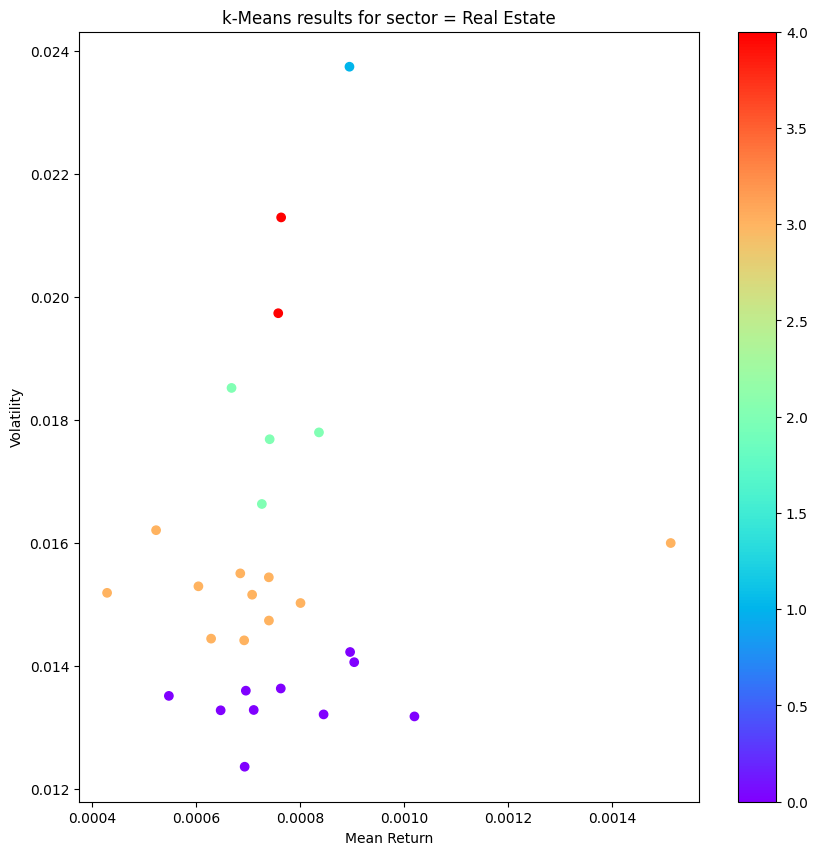

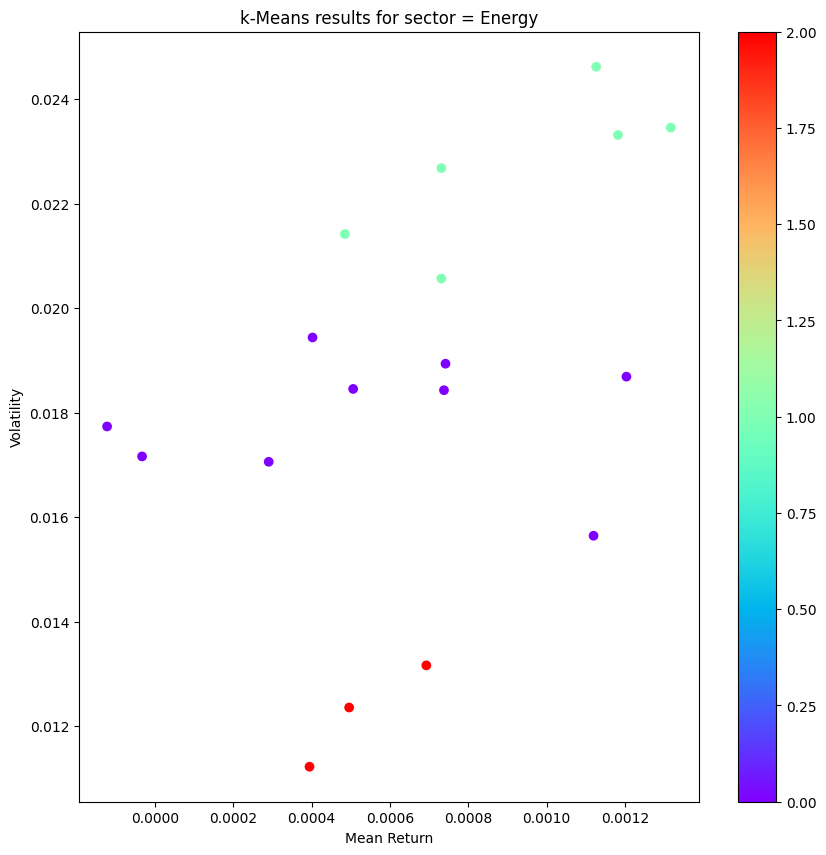

In [107]:
num_clusters_kmeans = [5,5,4,4,4,5,4,4,4,5,3]

for i, sector in enumerate(sectors):
    
    X = df_aggs['train'][sector]
    
    k_means = cluster.KMeans(n_clusters = num_clusters_kmeans[i],n_init=100)
    k_means.fit(X.loc[:,['Mean','Volatility']])
    target_labels = k_means.predict(X.loc[:,['Mean','Volatility']])
    

    centroids = k_means.cluster_centers_
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(X.iloc[:,0],
                         X.iloc[:,1],
                         c = k_means.labels_, 
                         cmap ="rainbow")
    
    ax.set_title(f'k-Means results for sector = {sector}')
    ax.set_xlabel('Mean Return')
    ax.set_ylabel('Volatility')
    plt.colorbar(scatter)
    

### Hierarchical

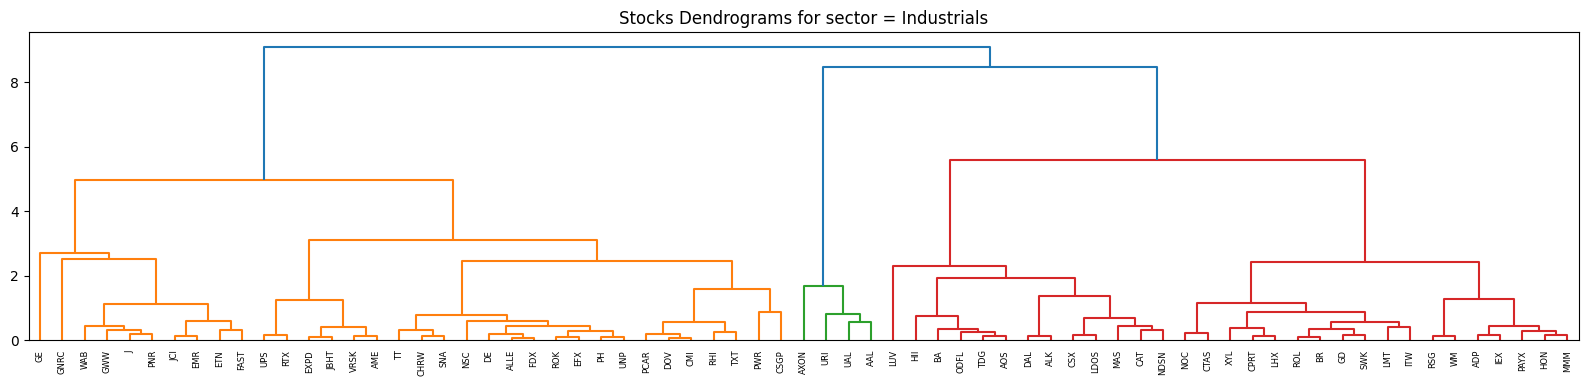

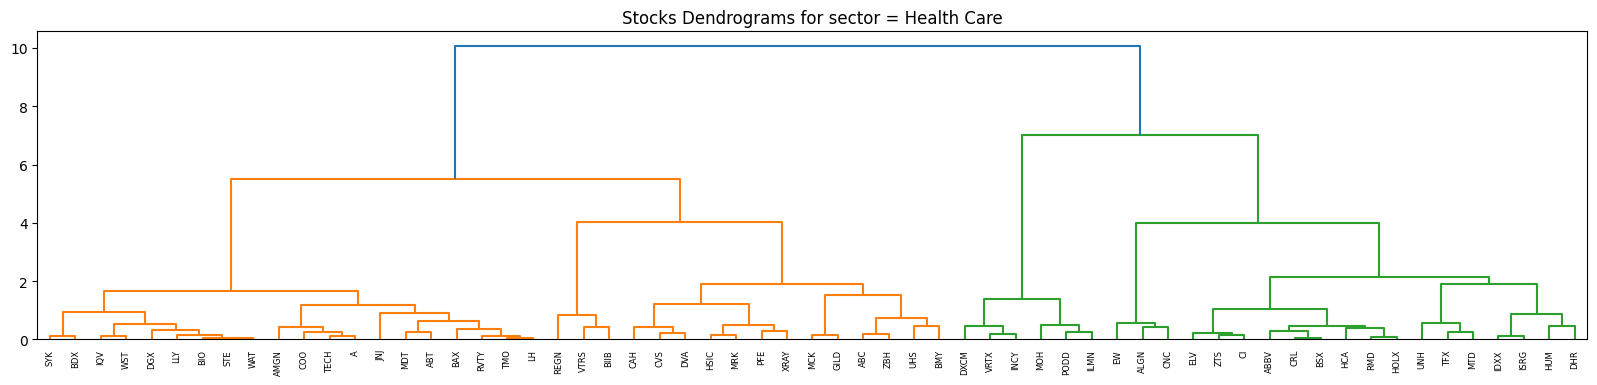

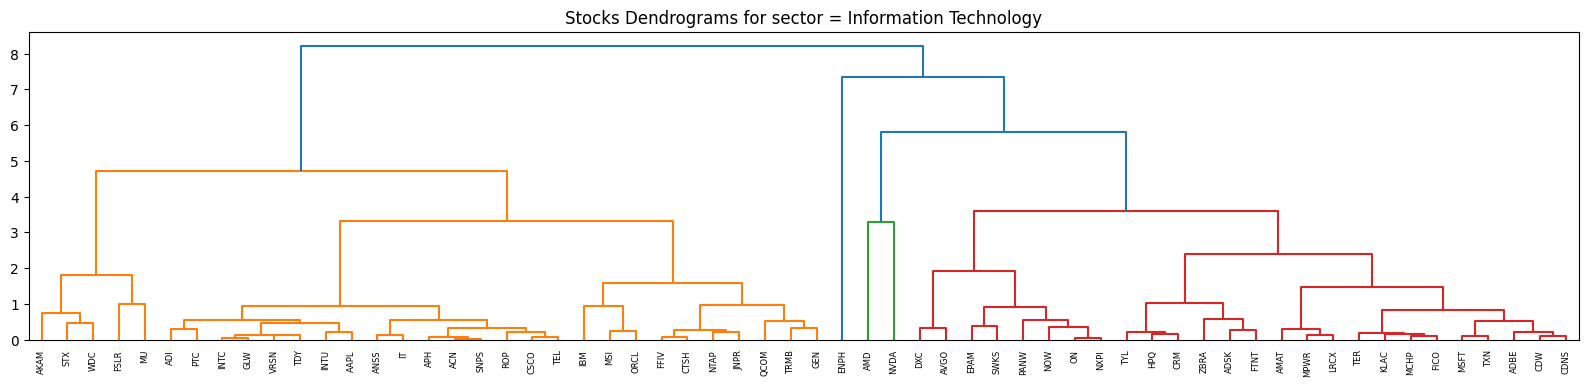

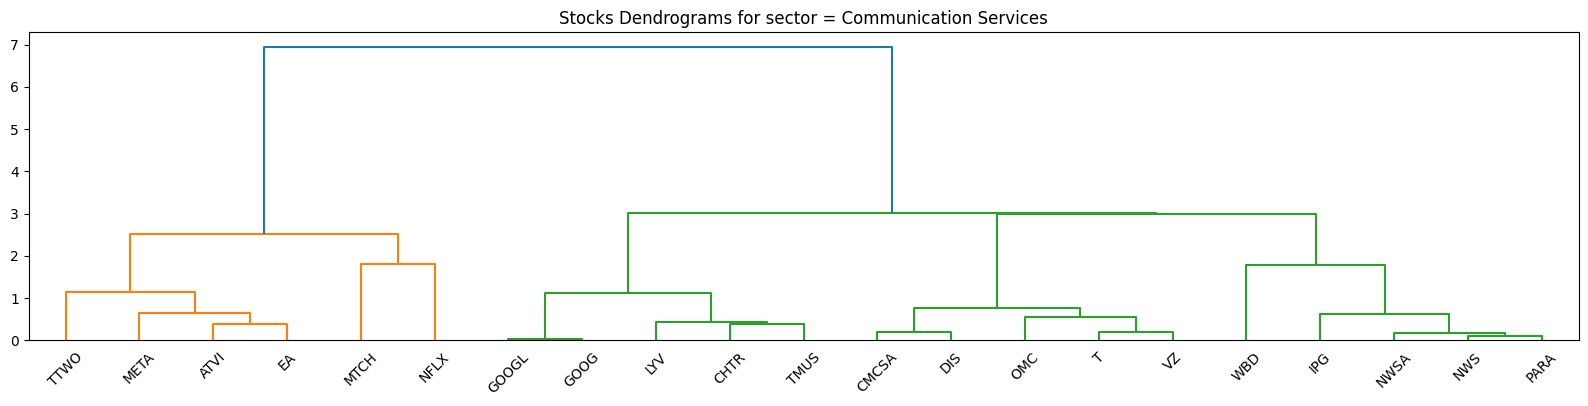

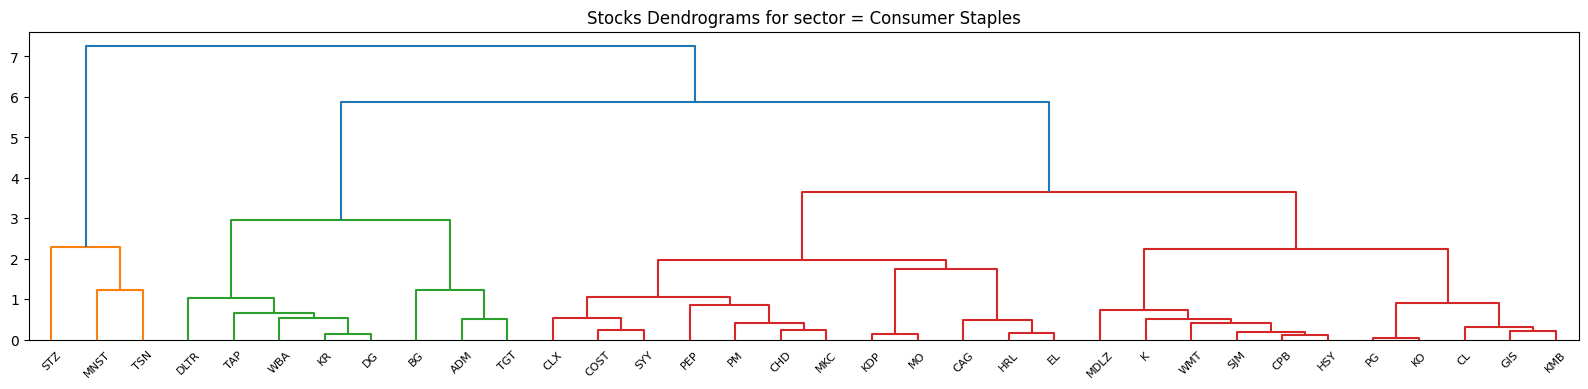

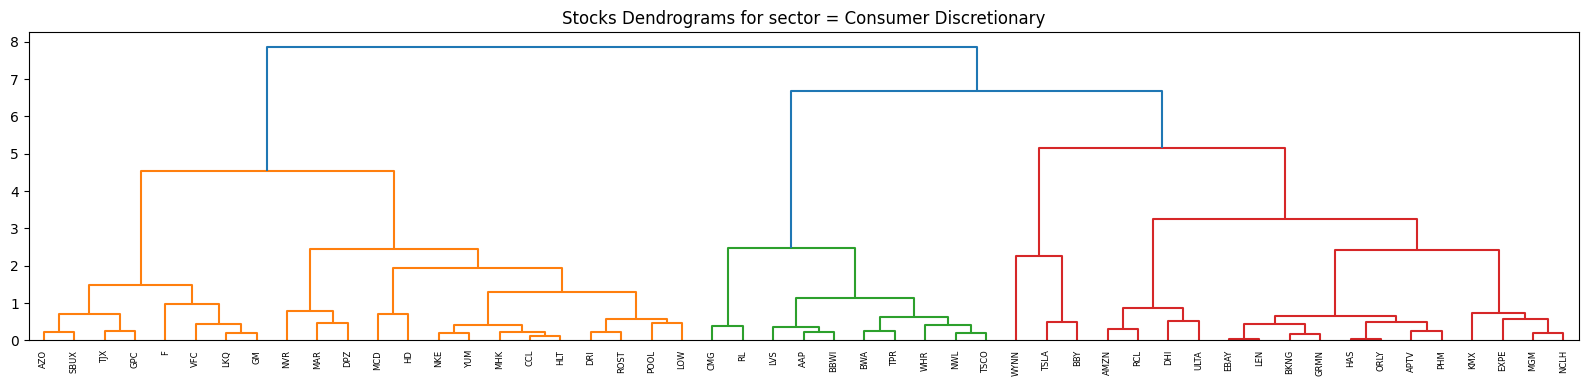

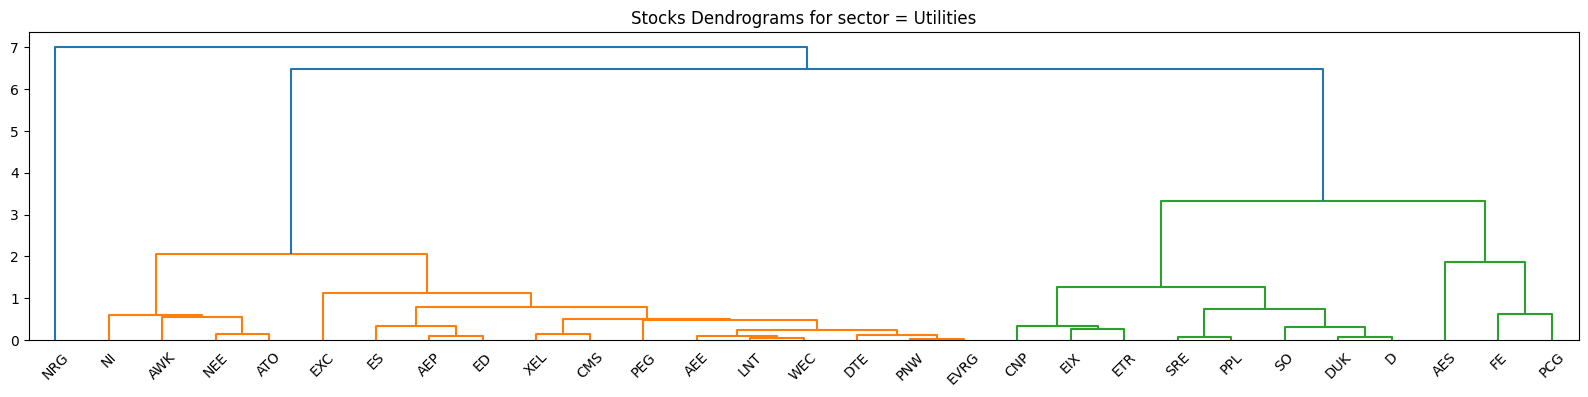

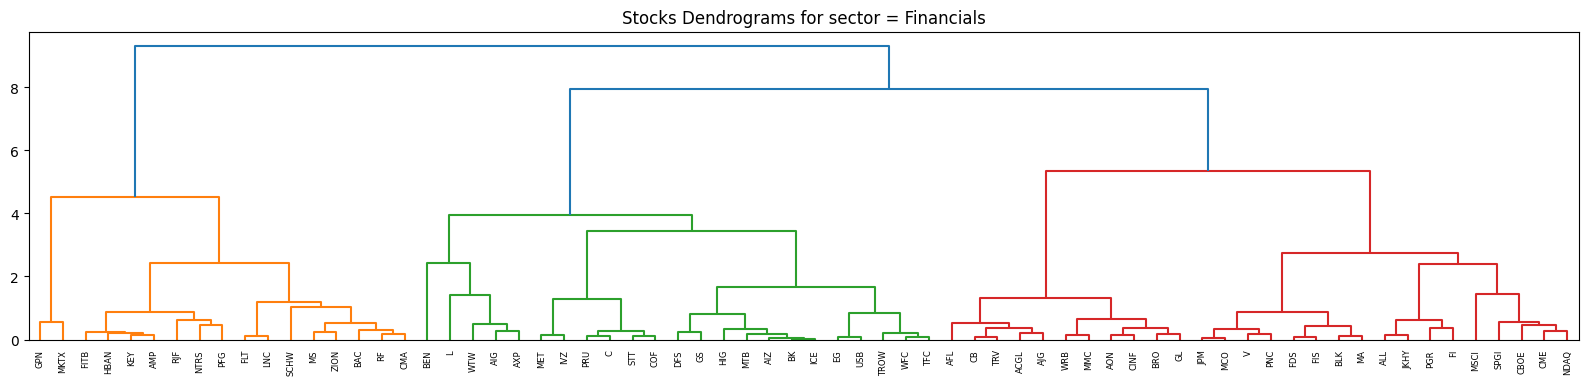

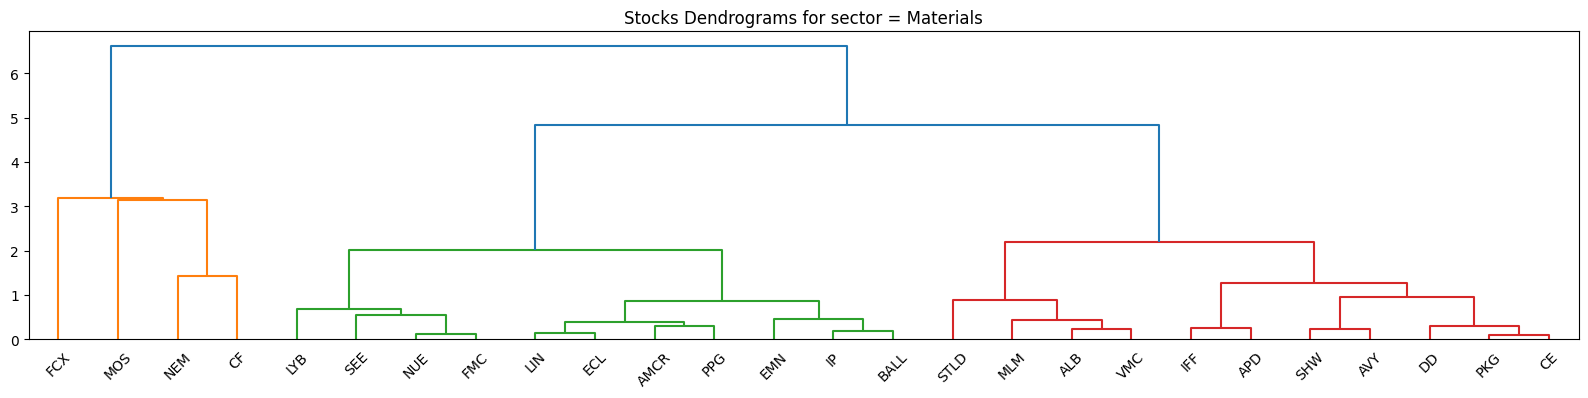

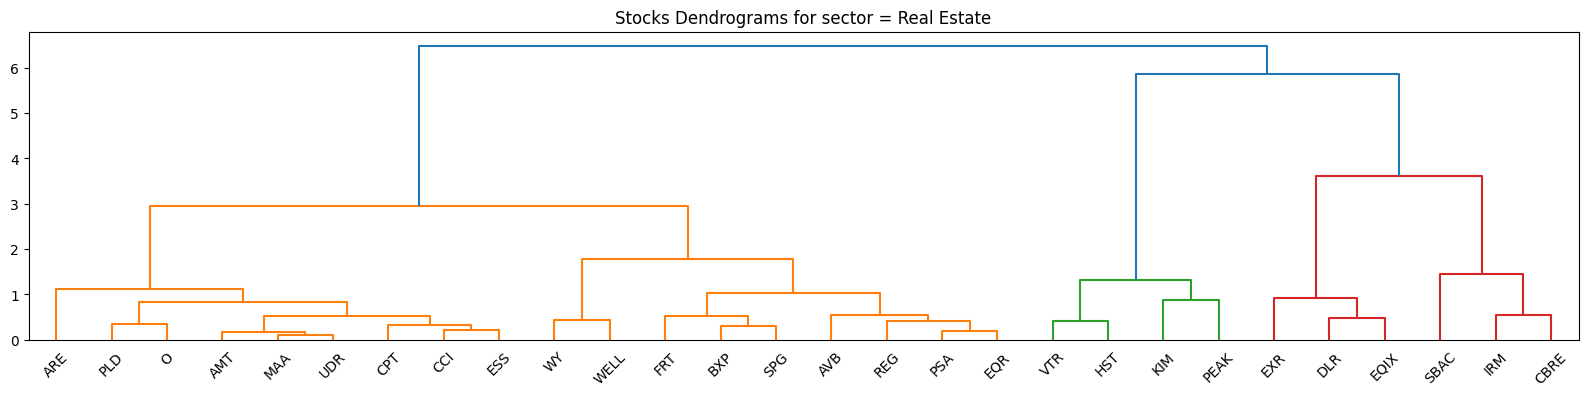

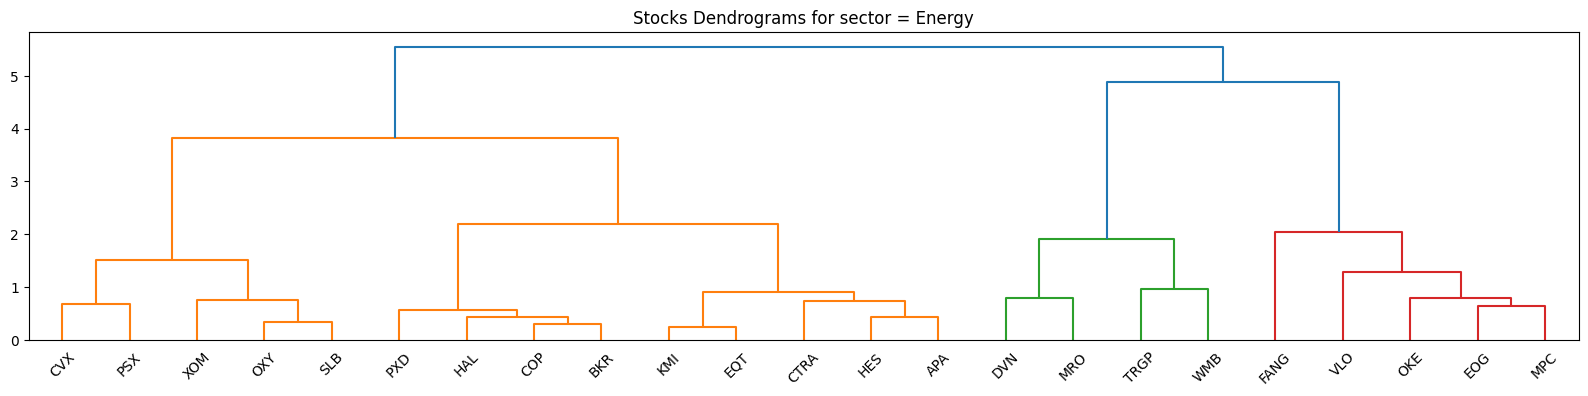

Total number of pairs to check: 4959.0


In [216]:
from scipy.cluster.hierarchy import dendrogram, linkage, ward

Z_sec = {}

for sector in sectors:
    #Calulate linkage
    Z_sec[sector] = linkage(df_aggs['train'][sector].loc[:,['Returns','Volatility']], method='ward')

total_pairs = 0
num_clusters_dend = {}

for sector in sectors:
    plt.figure(figsize=(20,4))
    plt.title(f"Stocks Dendrograms for sector = {sector}")
    
    dend = dendrogram(Z_sec[sector],labels = df_aggs['train'][sector].index)
    counts = Counter(dend['leaves_color_list'])

    num_clusters_dend[sector] = len(counts)
    
    for x in counts.values():
        total_pairs += x*(x-1)*1/2.
    plt.show()
    
print(f'Total number of pairs to check: {total_pairs}')

### Affinity

Total number of pairs to check: 1991.0


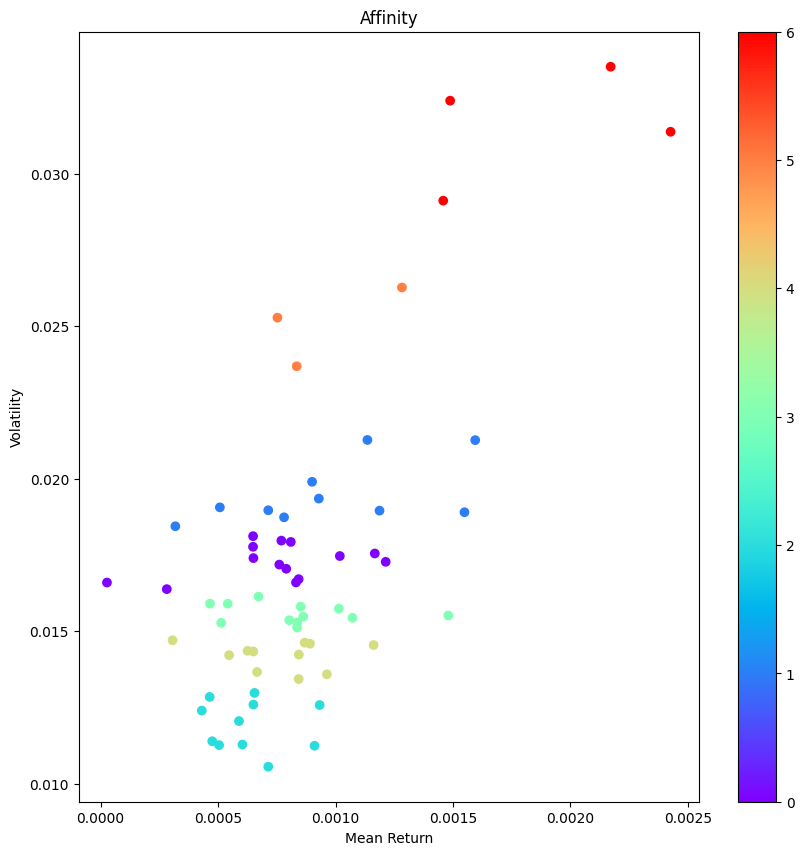

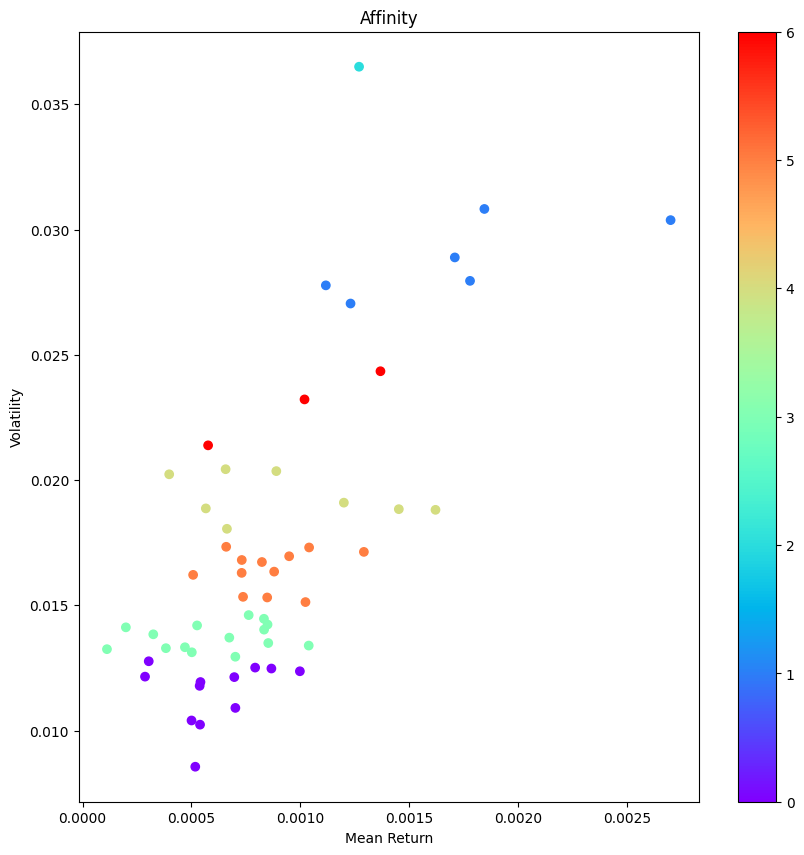

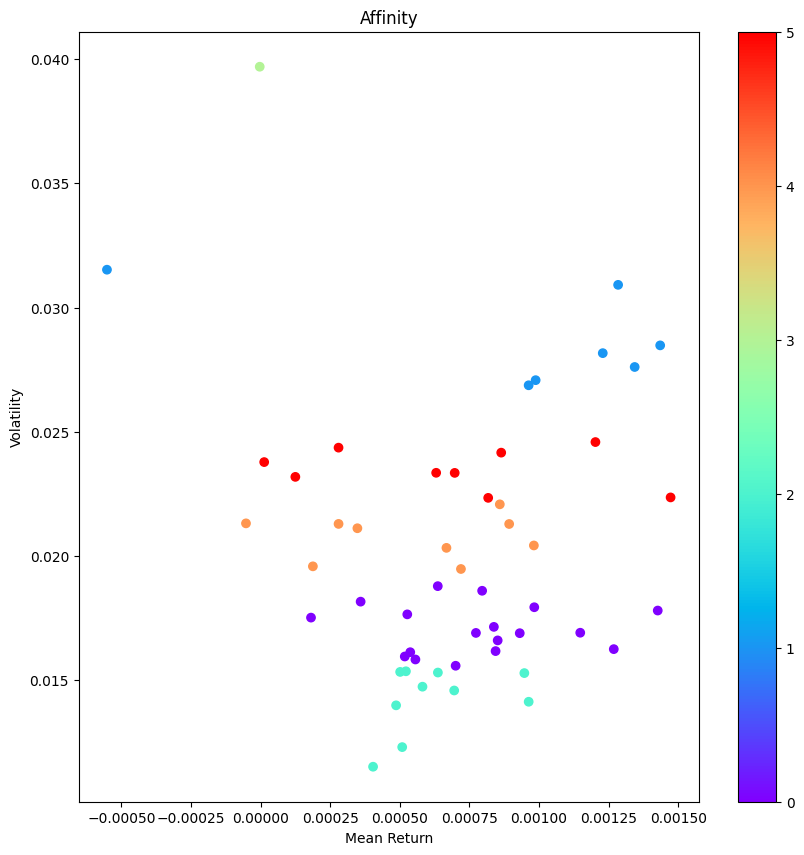

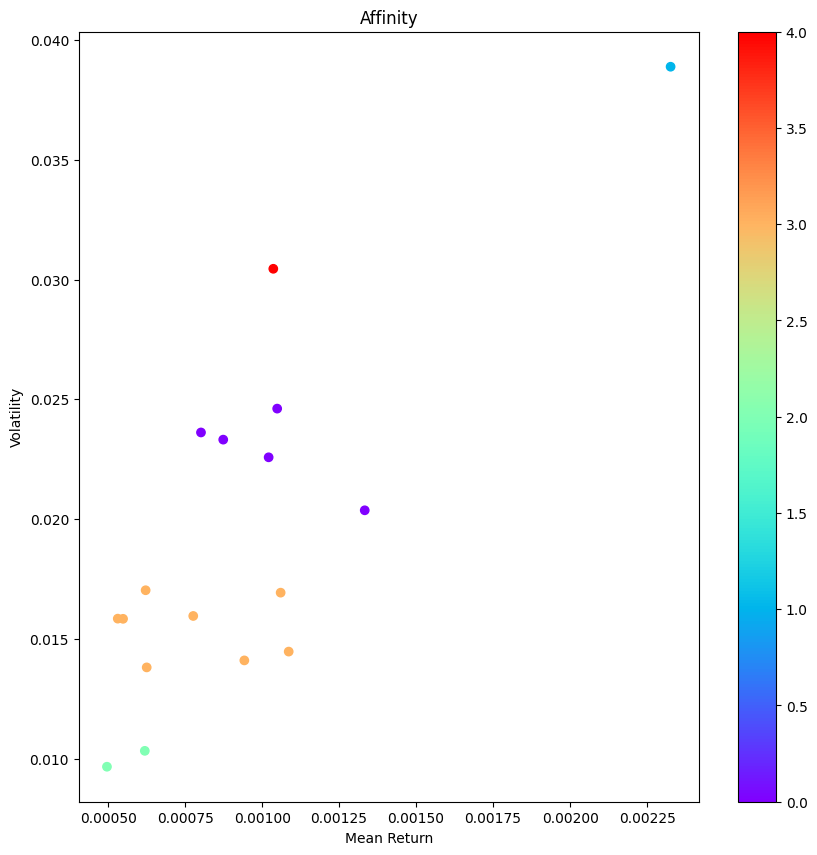

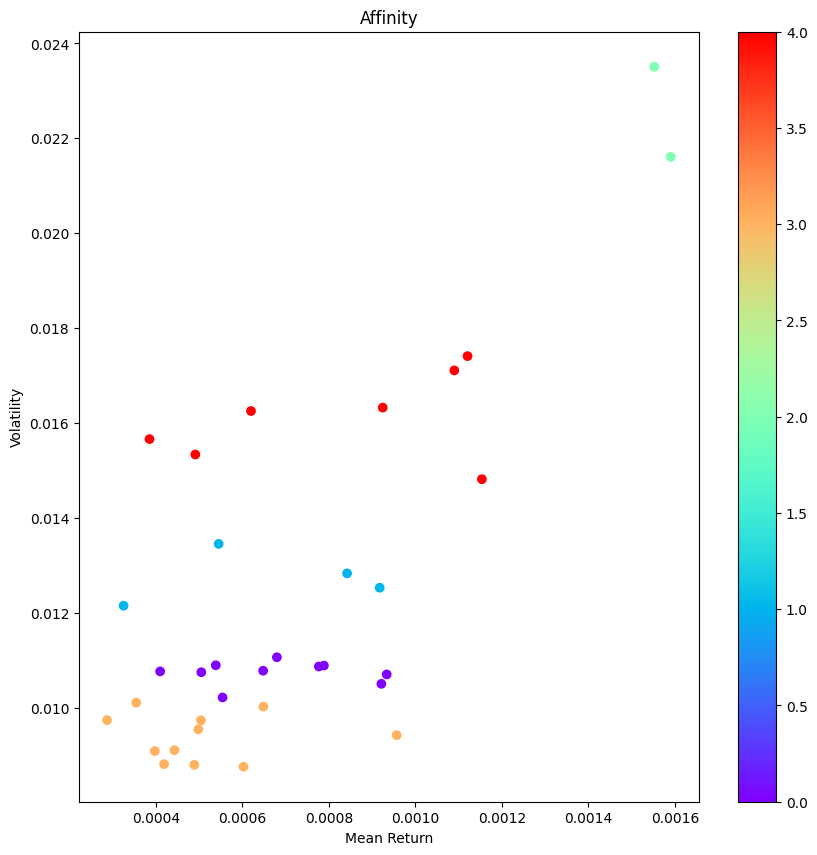

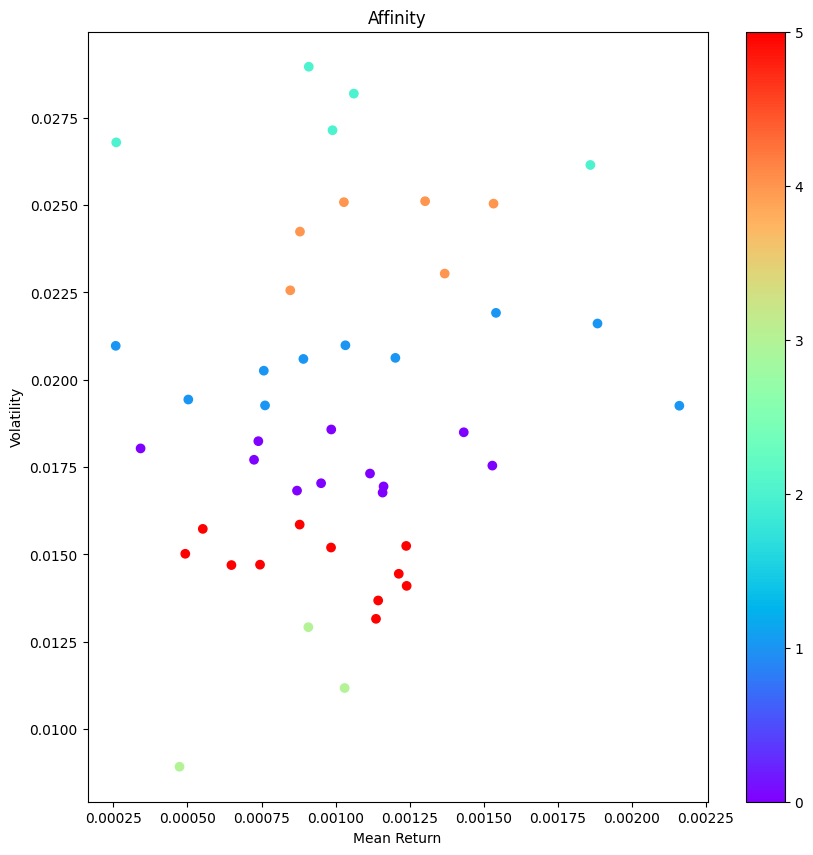

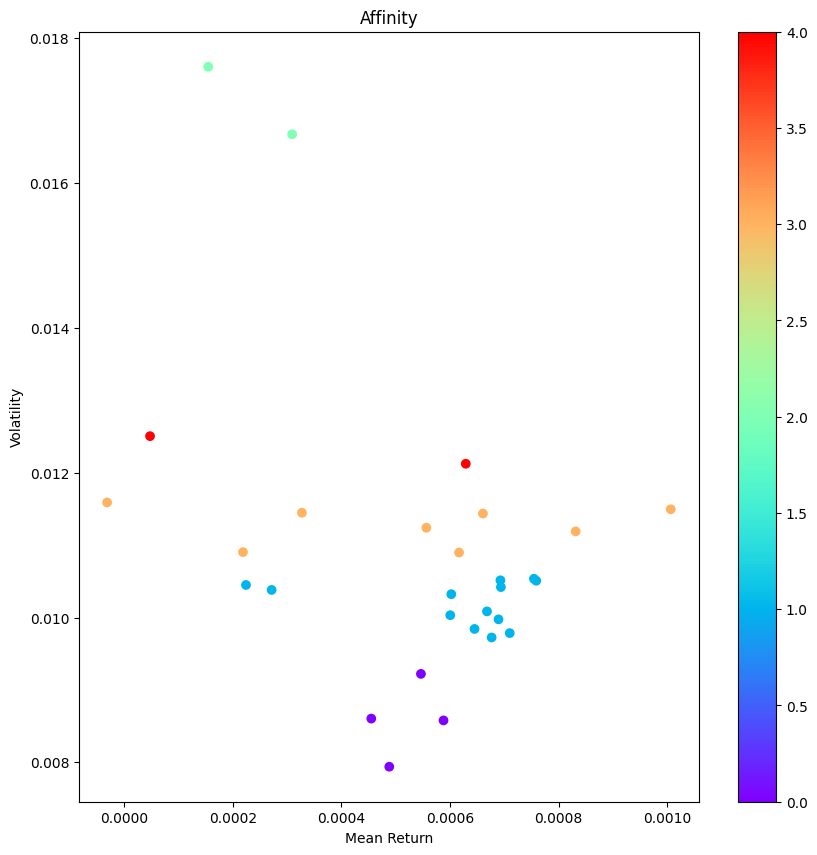

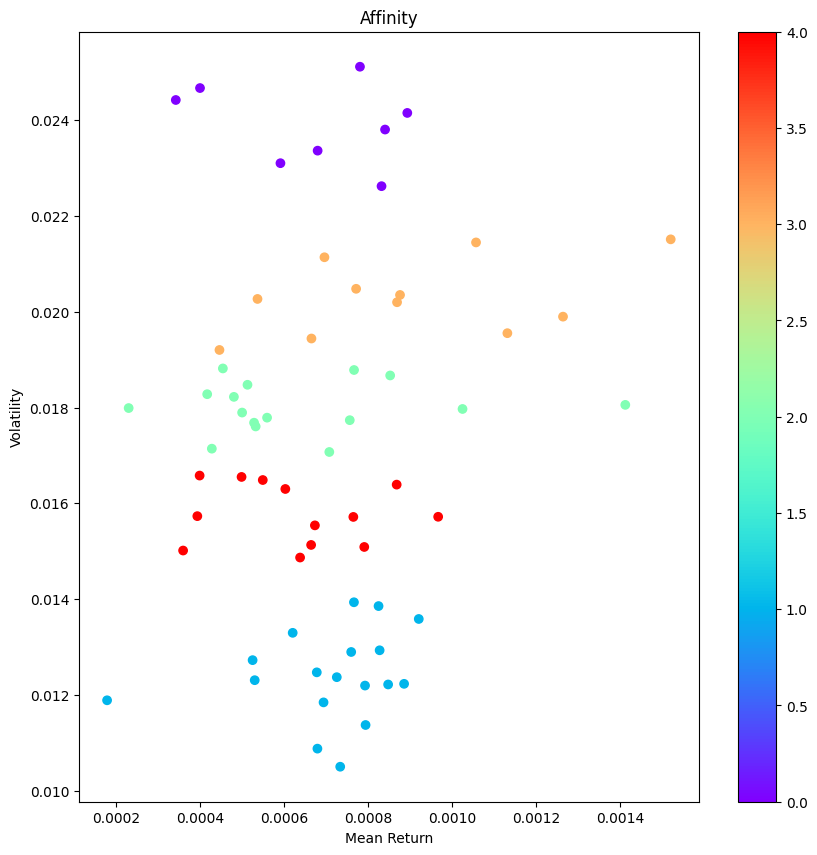

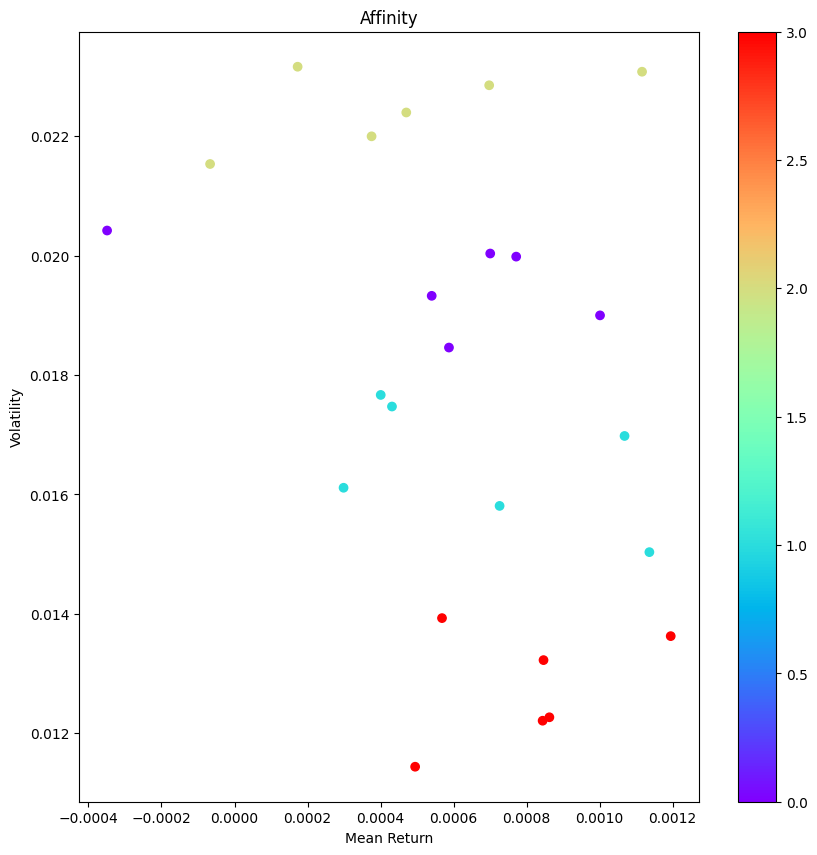

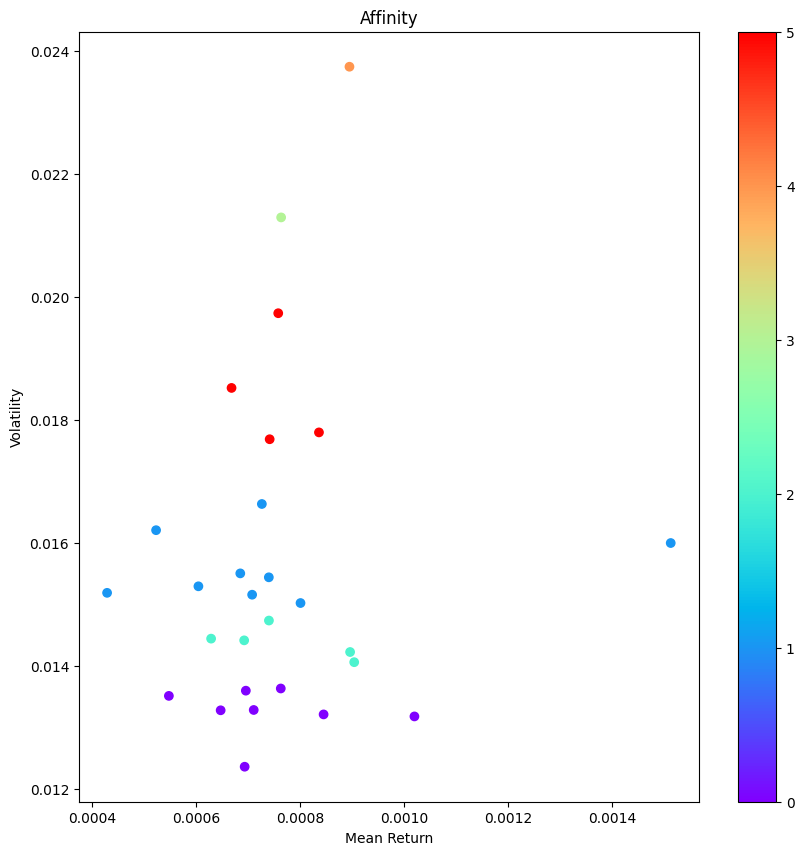

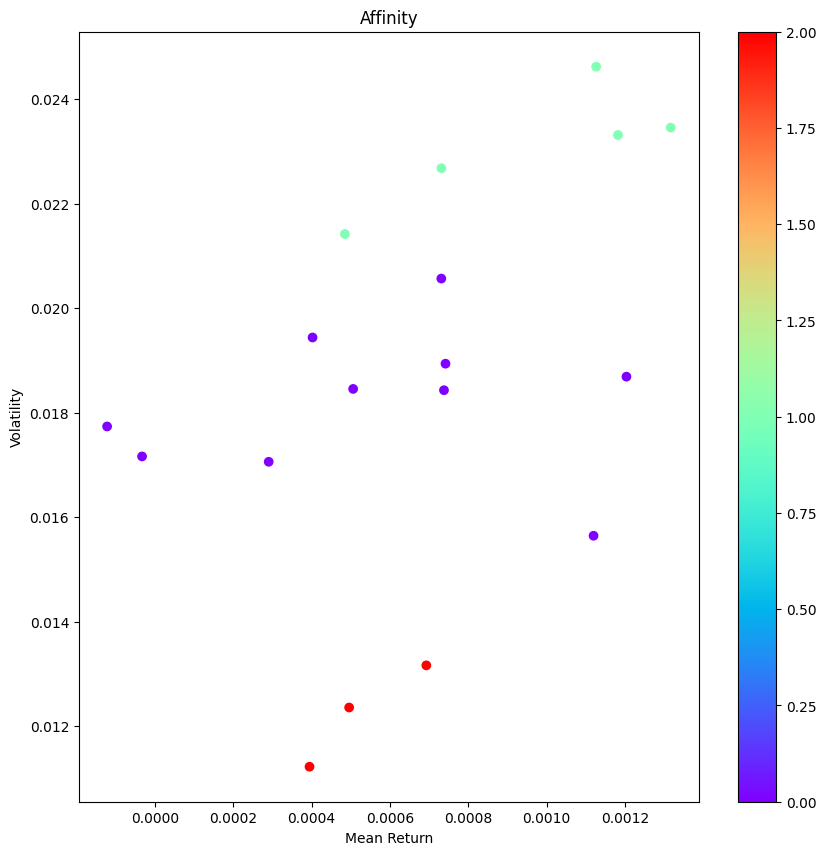

In [108]:
clust_labels_ap = {}
tot_pairs = 0

for sector in sectors:
    ap = AffinityPropagation()
    ap.fit(df_aggs['train'][sector].loc[:,['Mean','Volatility']])
    clust_labels_ap[sector] = ap.predict(df_aggs['train'][sector].loc[:,['Mean','Volatility']])
    
    for x in Counter(clust_labels_ap[sector]).values():
        tot_pairs += x*(x-1)*.5

print(f'Total number of pairs to check: {tot_pairs}')
        
for sector in sectors:

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(df_aggs['train'][sector].iloc[:,0],df_aggs['train'][sector].iloc[:,1], c= clust_labels_ap[sector], cmap ="rainbow")
    ax.set_title('Affinity')
    ax.set_xlabel('Mean Return')
    ax.set_ylabel('Volatility')
    plt.colorbar(scatter)

### Optics

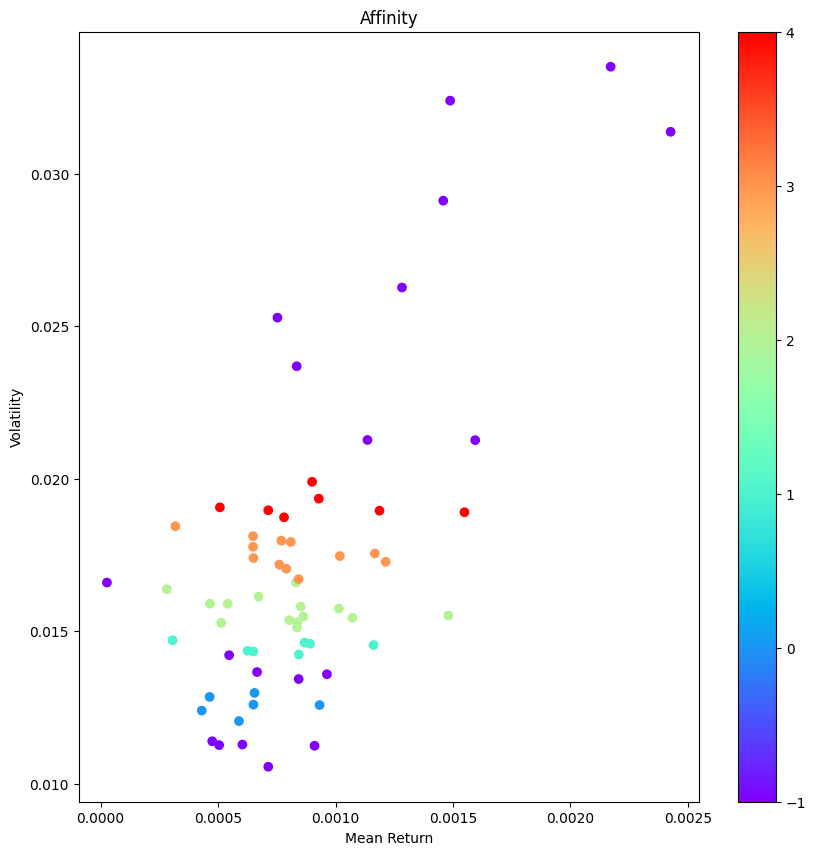

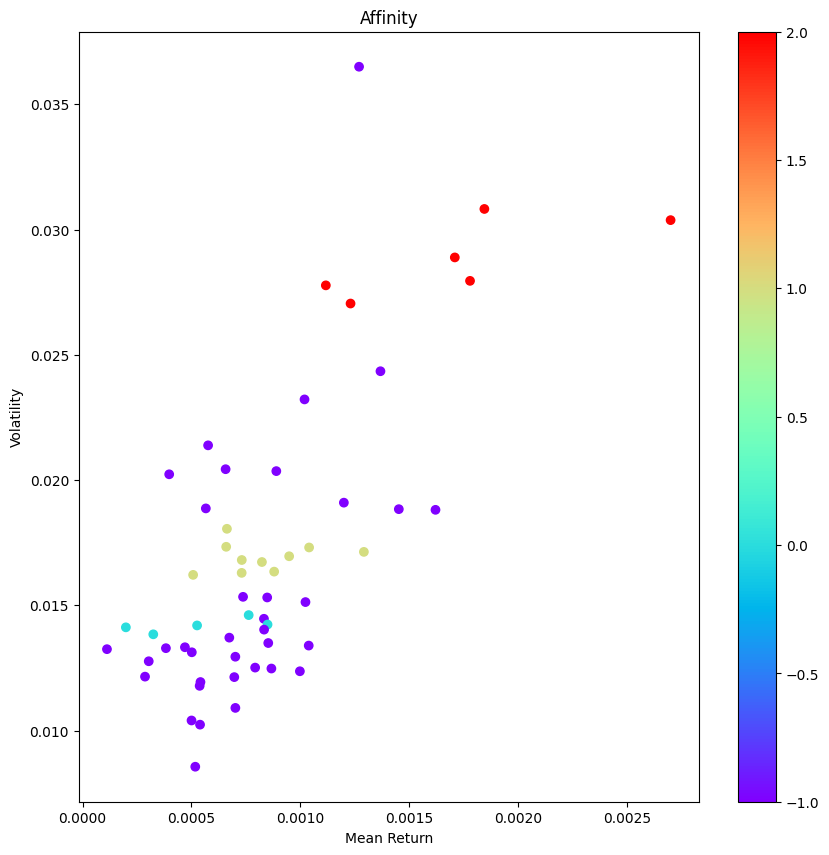

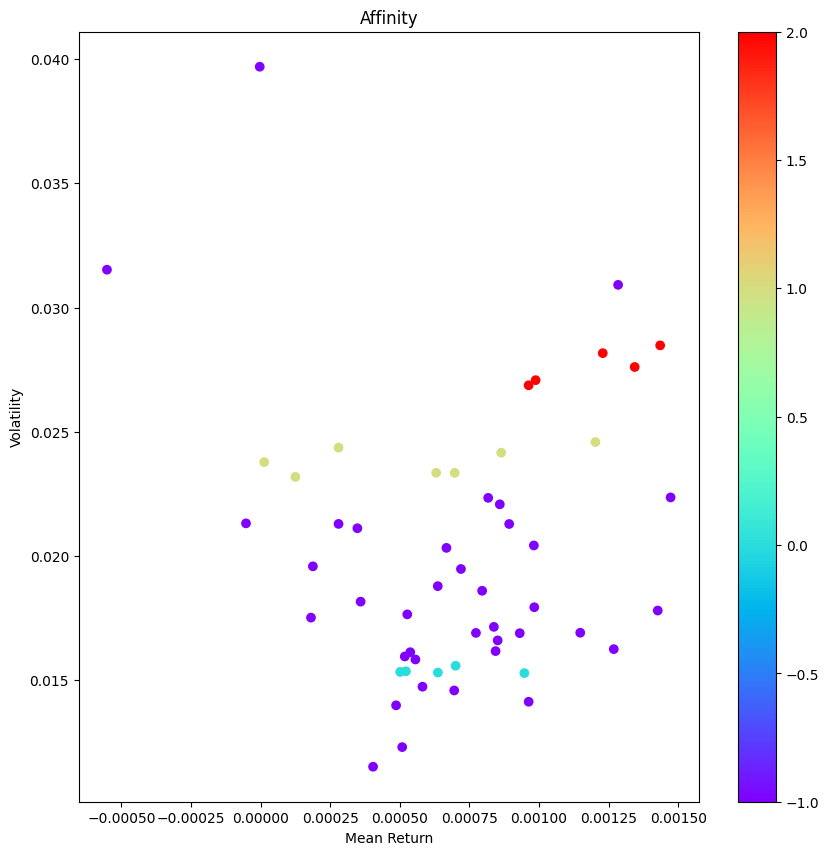

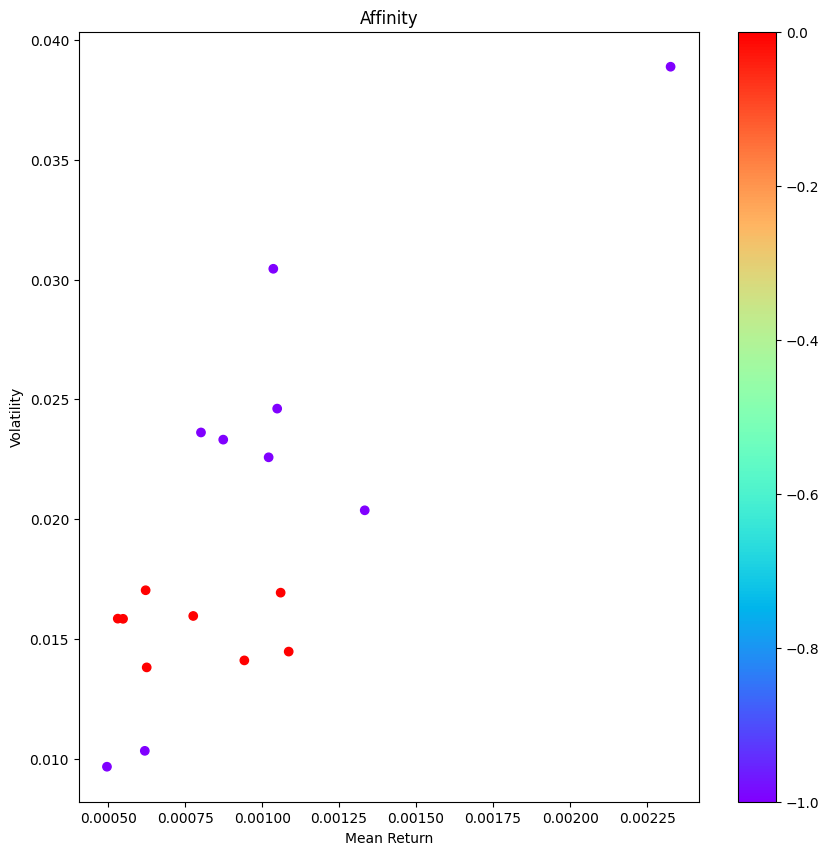

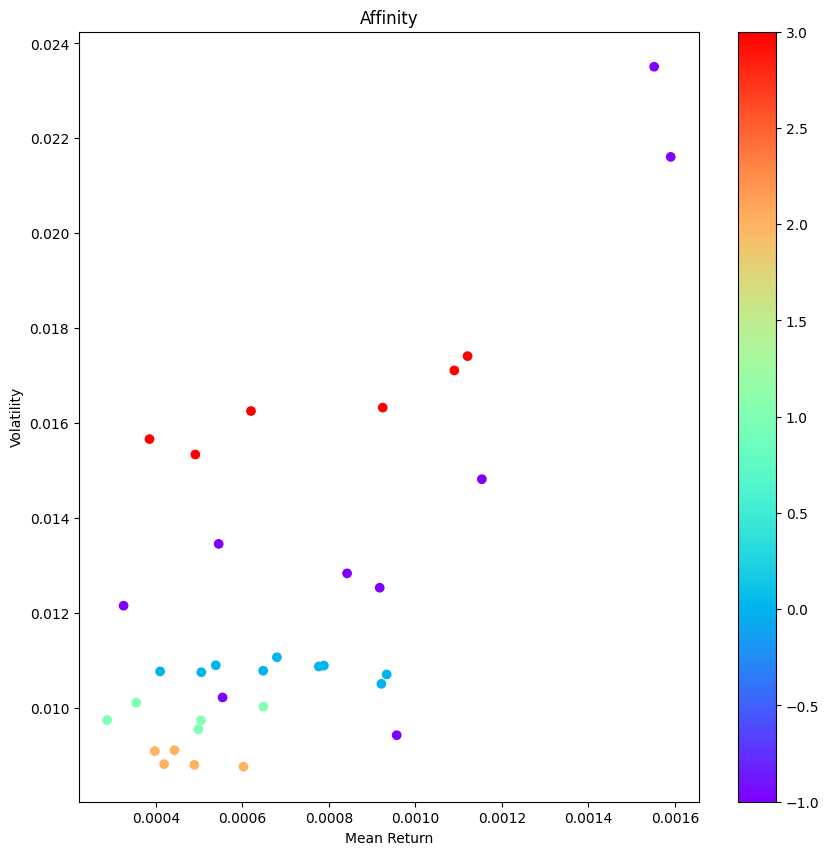

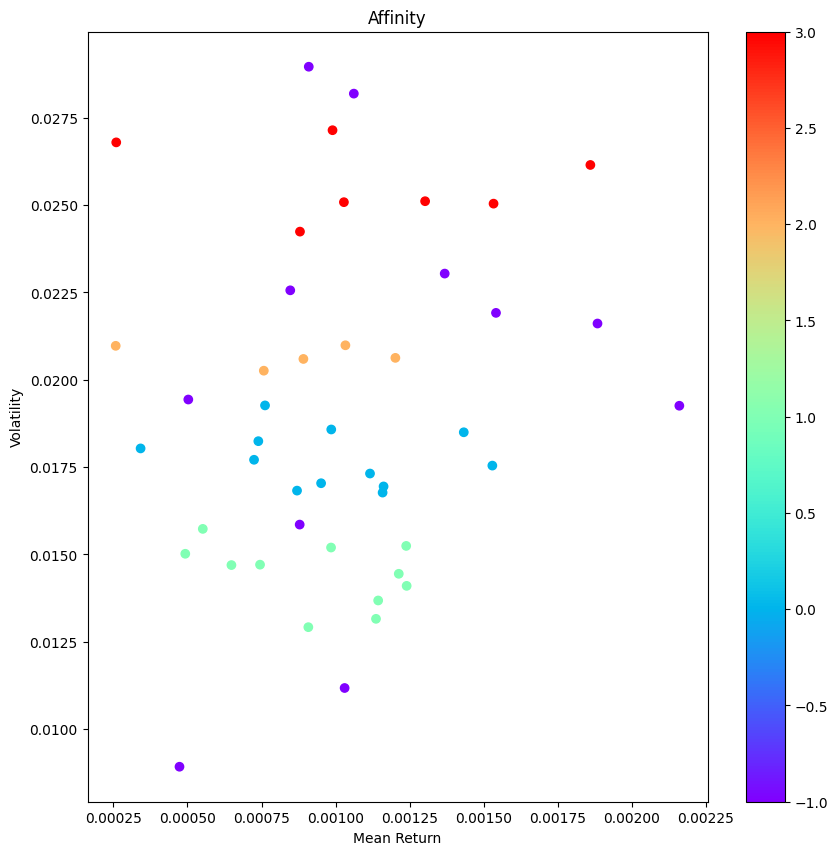

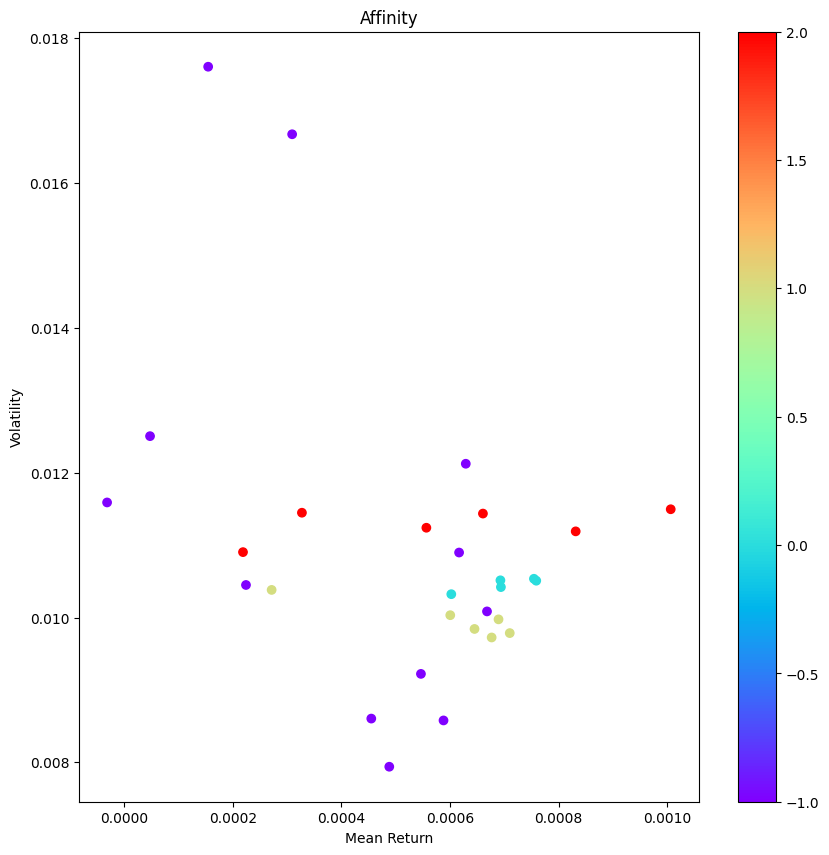

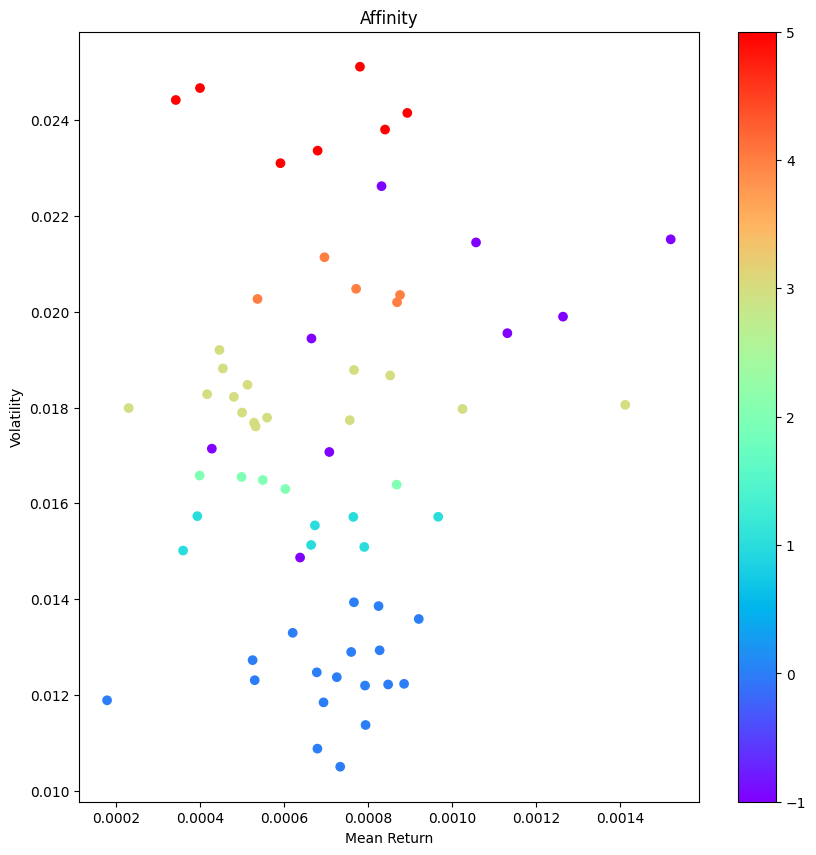

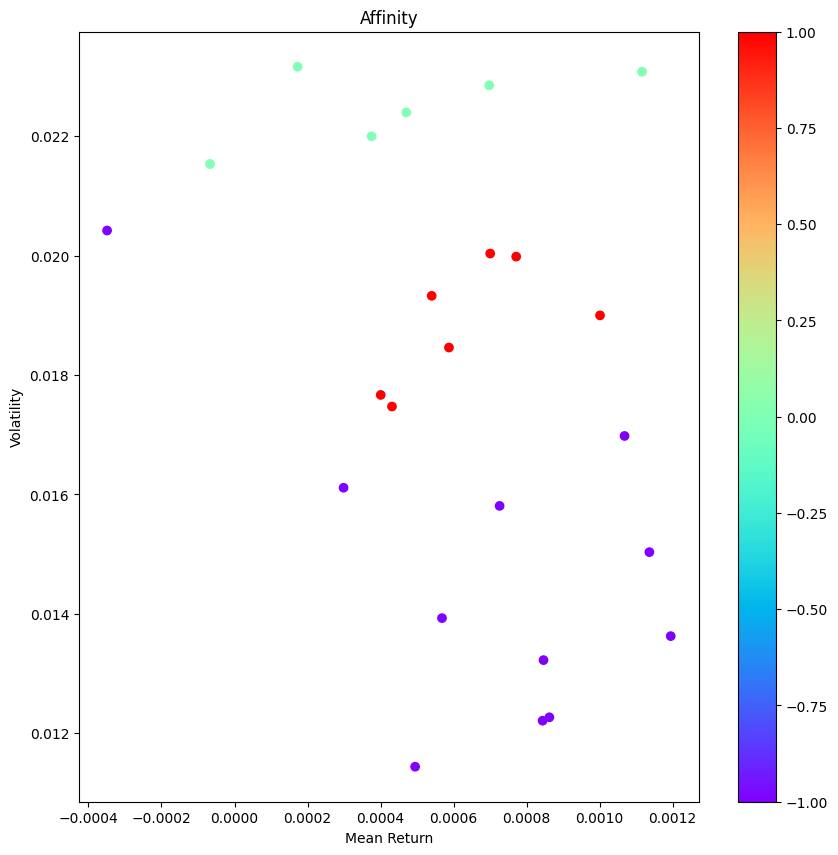

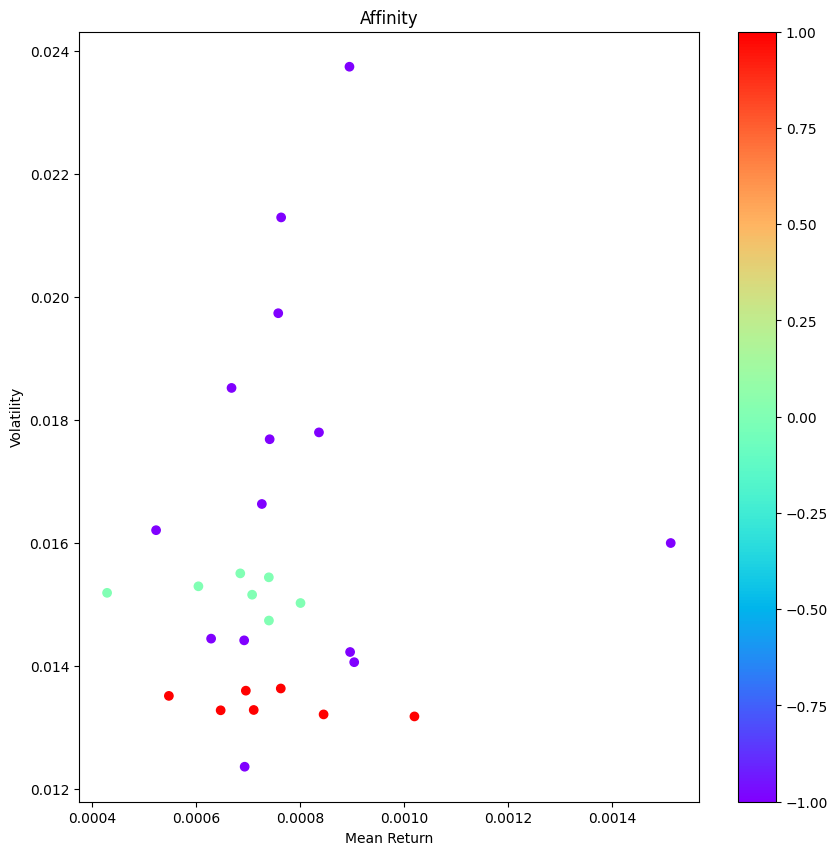

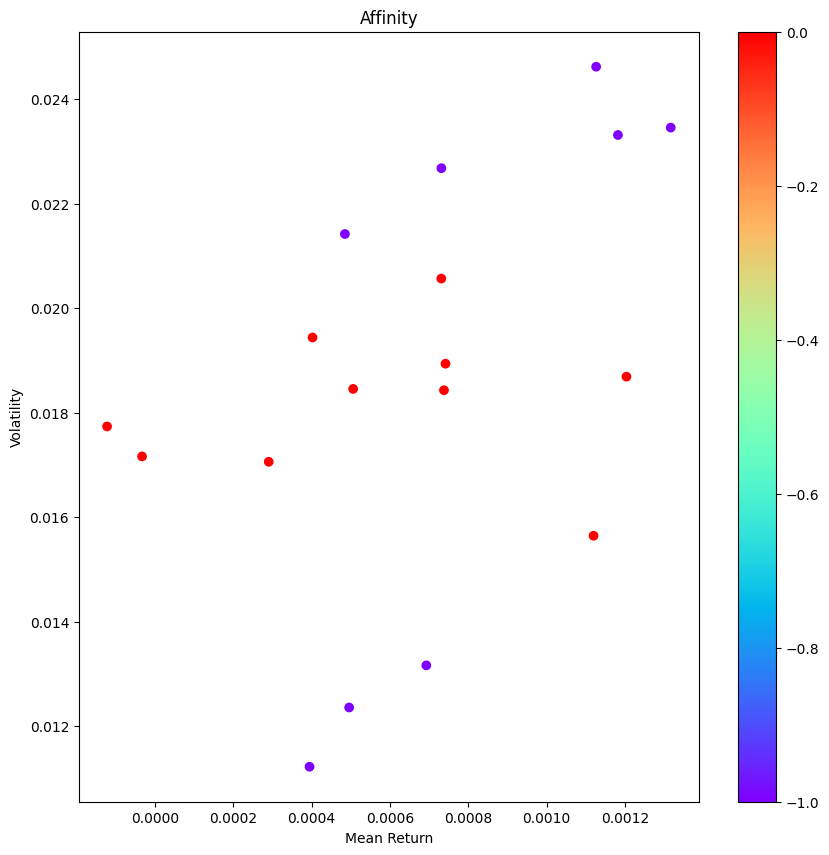

In [113]:
optics_labels = {}
sector_counts = {}

for sector in sectors:
    X = df_aggs['train'][sector].loc[:,['Mean','Volatility']]
    
    optics_labels[sector] = OPTICS().fit_predict(X)
    sector_counts[sector] = 0

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    scatter = ax.scatter(df_aggs['train'][sector].iloc[:,0],
                         df_aggs['train'][sector].iloc[:,1],
                         c = optics_labels[sector],
                         cmap ="rainbow")
   
    ax.set_title('Affinity')
    ax.set_xlabel('Mean Return')
    ax.set_ylabel('Volatility')
    
    plt.colorbar(scatter)
    
    counts = Counter(optics_labels[sector])
    for label, count in counts.items():
        if label == -1:
            continue
        else:
            sector_counts[sector] += count*(count-1)*.5
        

In [112]:
optics_labels

{'Industrials': array([-1,  2,  2, -1,  3, -1,  2,  4,  2,  4,  0, -1,  1,  2,  2,  3, -1,
         2,  1,  4,  0,  1, -1,  3,  3,  0,  2, -1,  2,  0,  2,  2,  3, -1,
        -1, -1,  1,  2,  4,  3,  3,  1, -1,  2,  3, -1, -1,  0,  0,  1, -1,
        -1,  4,  3,  4, -1, -1,  2, -1,  3,  1,  3, -1,  3,  4]),
 'Health Care': array([-1,  1, -1, -1,  1,  1, -1,  2, -1,  0, -1, -1, -1, -1, -1,  2, -1,
         0, -1, -1, -1,  2, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  0,
        -1, -1,  1, -1, -1, -1, -1,  1,  0,  1,  2, -1,  0,  2, -1, -1,  1,
        -1, -1, -1, -1,  2,  1]),
 'Information Technology': array([-1, -1, -1, -1,  0,  1, -1,  2, -1, -1, -1, -1,  1,  0, -1,  1,  0,
         1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2, -1, -1,  0, -1, -1,
        -1, -1,  1, -1, -1, -1,  2,  2,  1,  1, -1, -1, -1, -1, -1, -1,  2,
        -1,  0, -1]),
 'Communication Services': array([-1, -1, -1, -1, -1,  0,  0, -1,  0,  0, -1,  0,  0, -1,  0,  0, -1]),
 'Consumer Staples': array([ 0,  0

## Features = [Mean, Volatility, Skew, Kurtosis]

### K-means

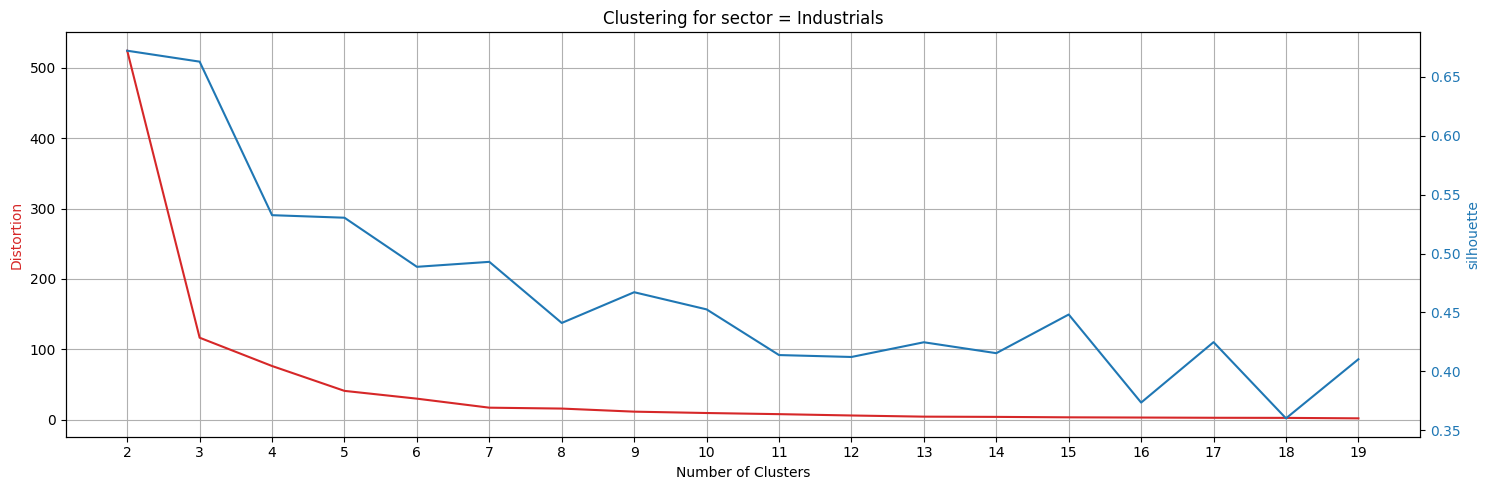

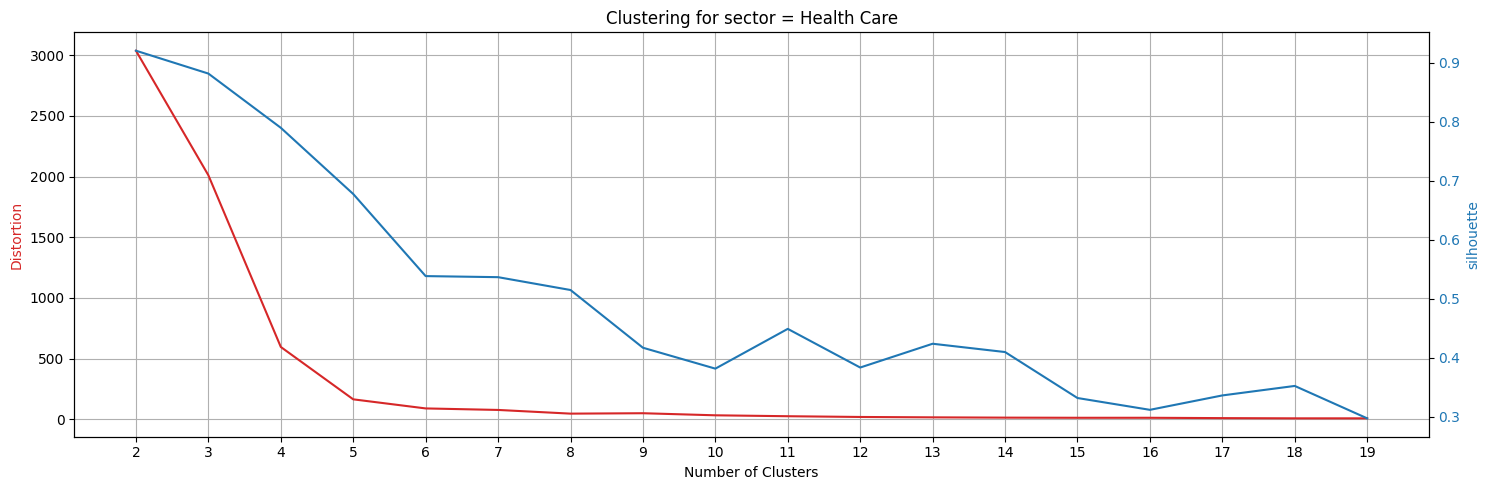

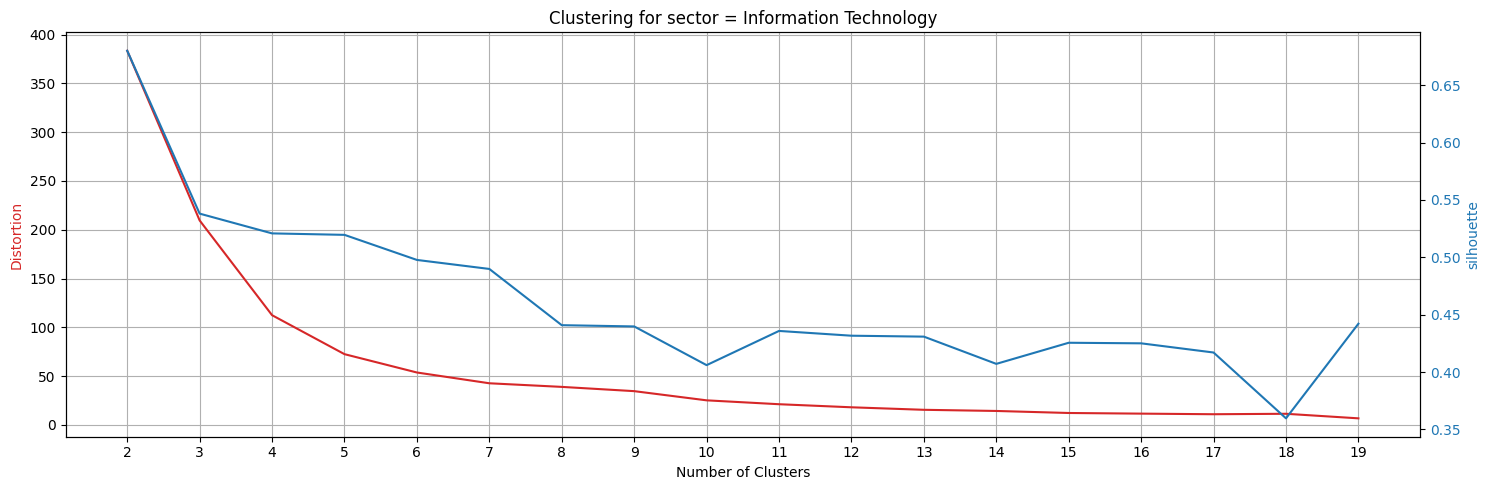

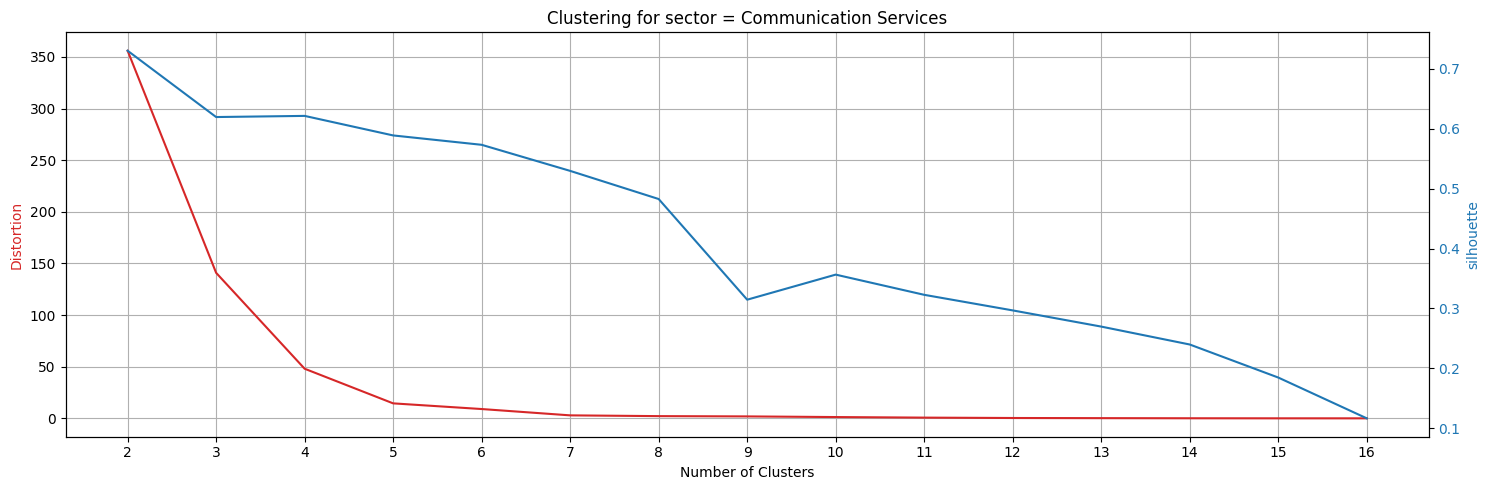

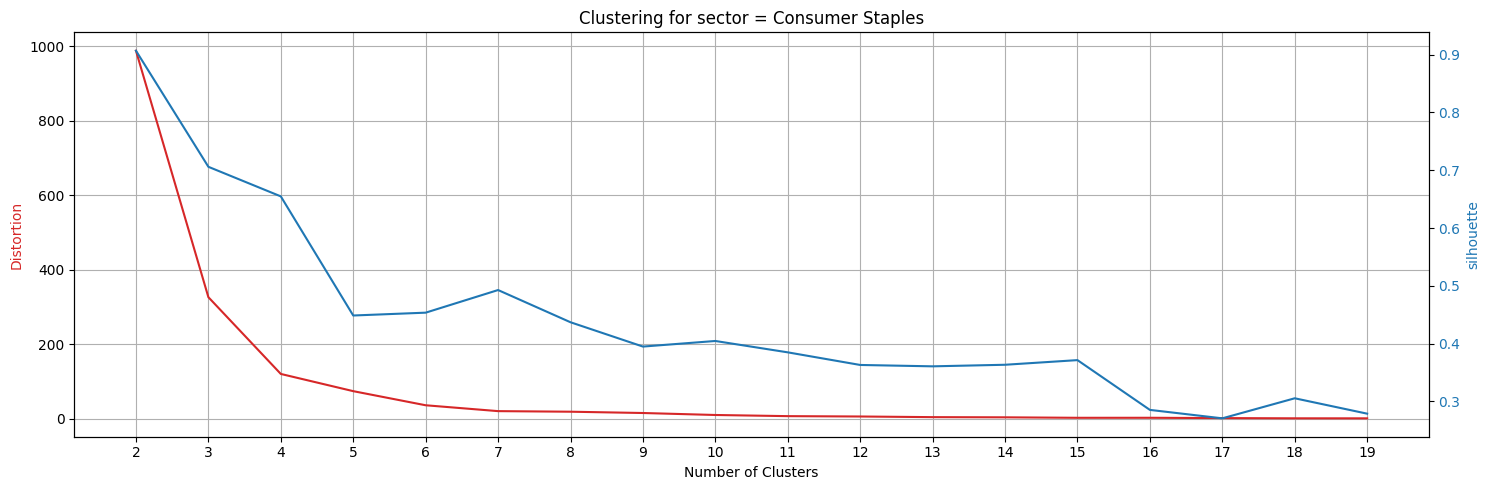

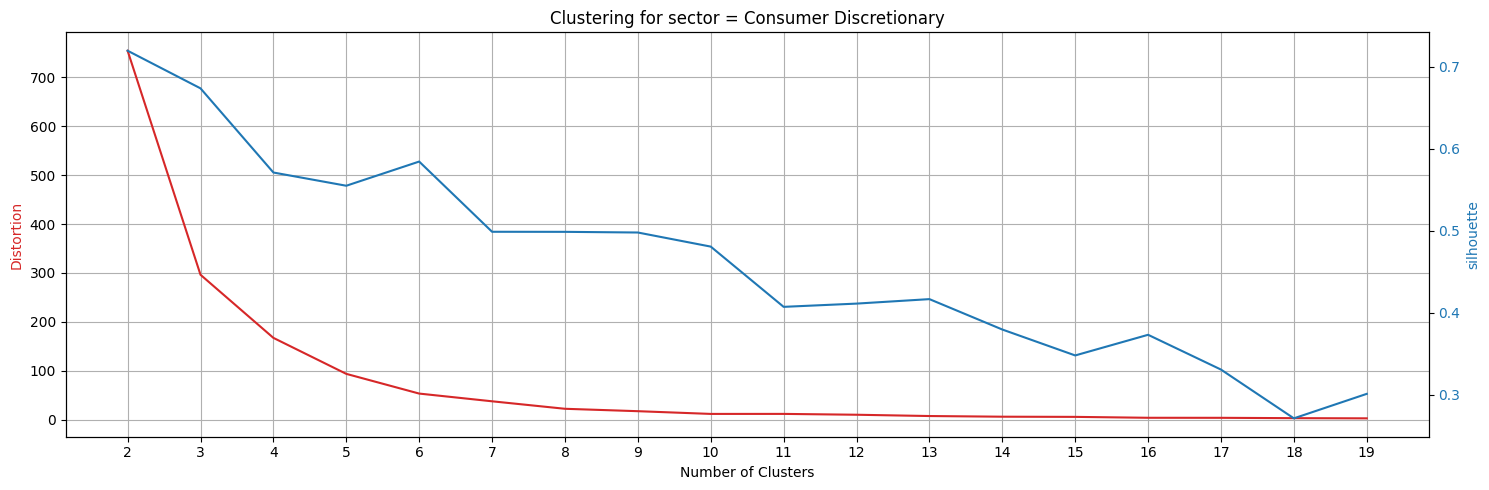

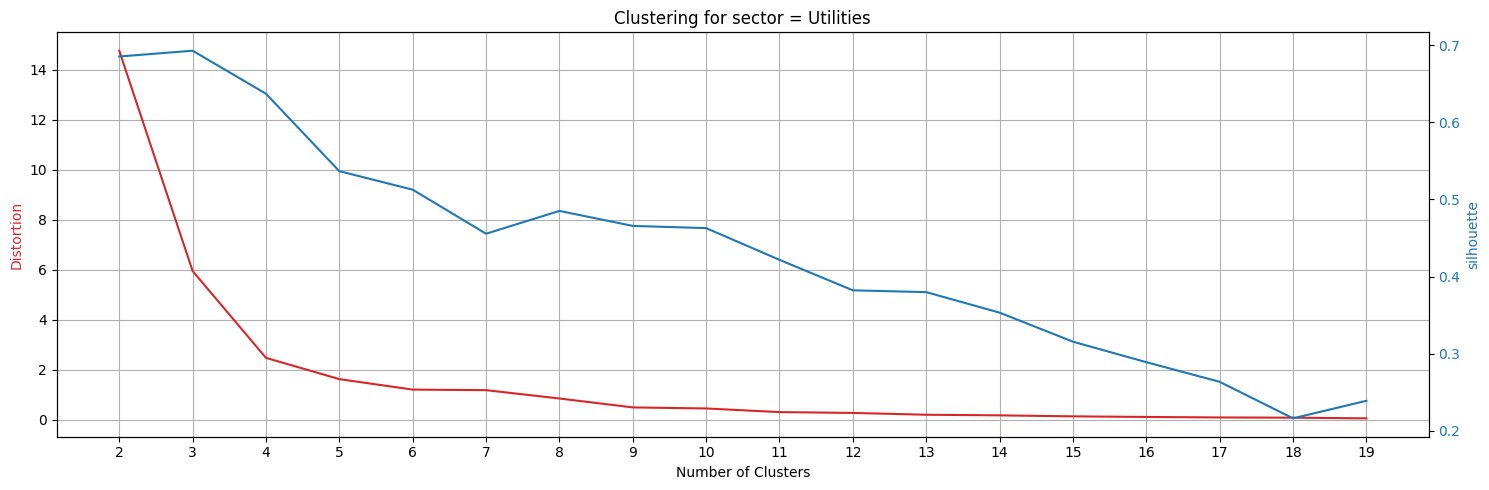

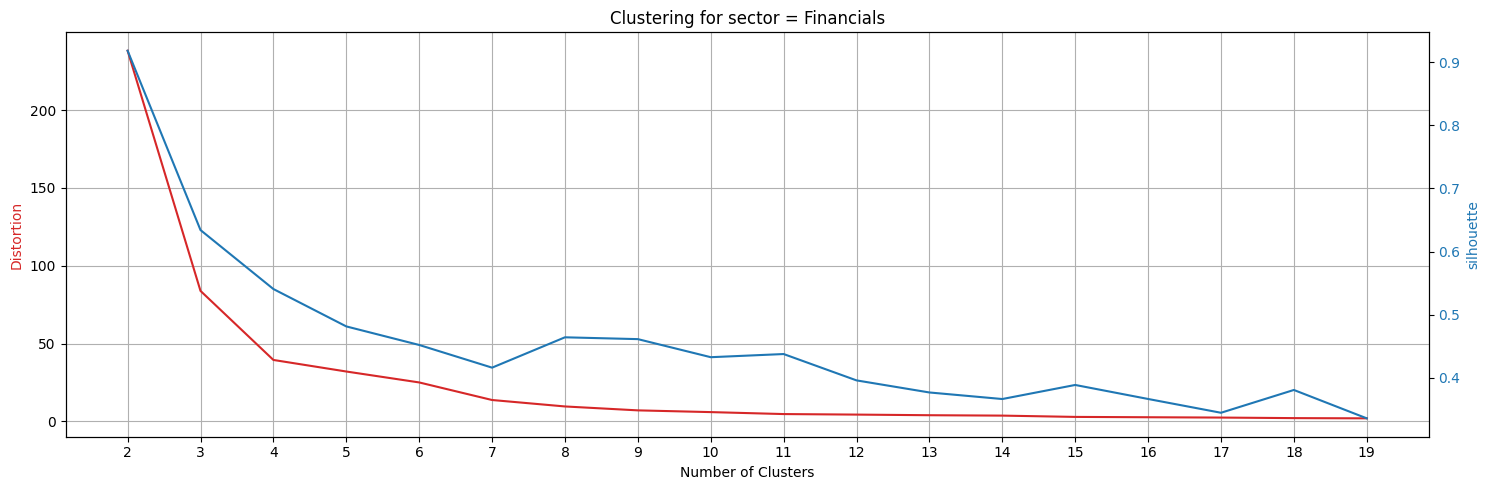

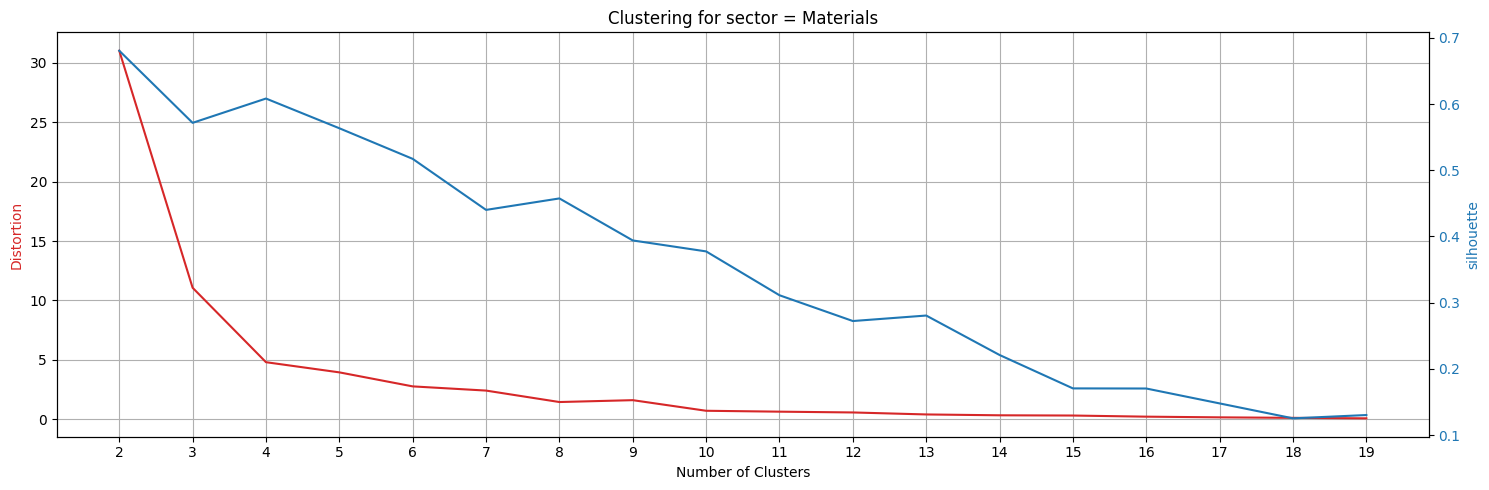

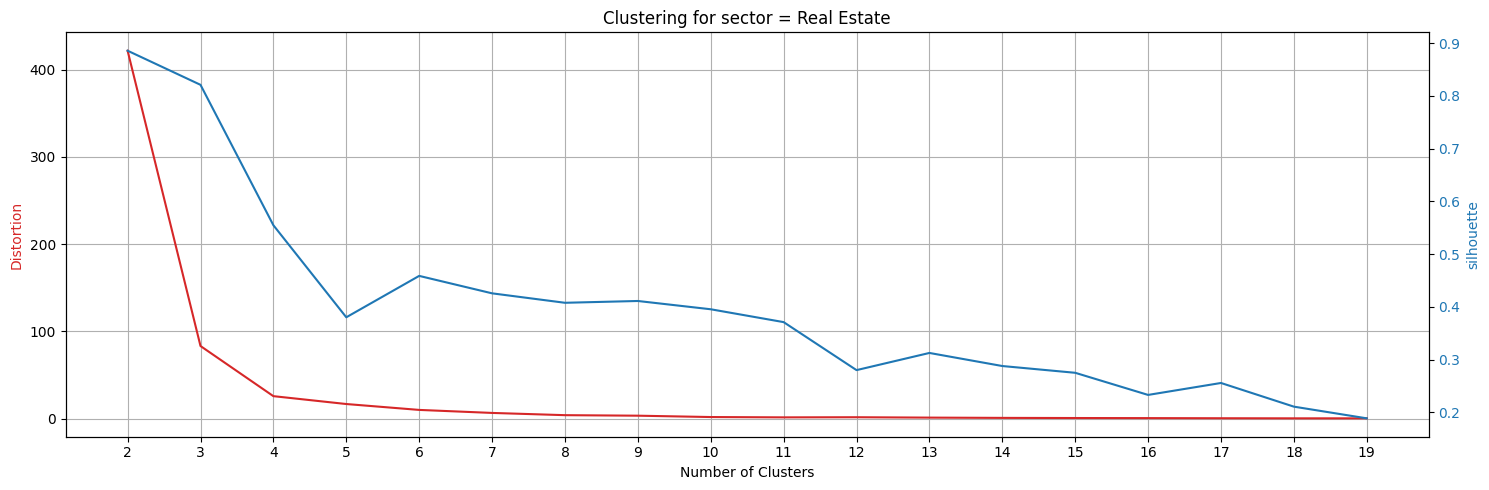

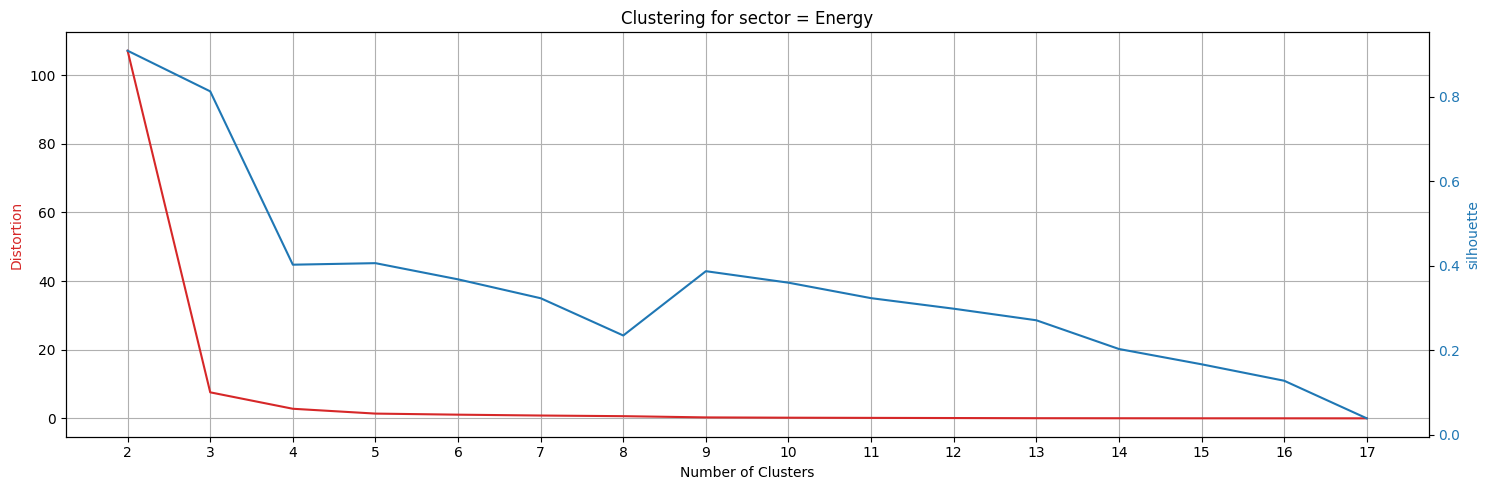

In [79]:
for sector in sectors:
    
    fig, ax1 = plt.subplots(figsize=(15, 5))
    
    color = 'tab:red'
    ax1.set_xlabel('Number of Clusters')
    ax1.set_ylabel('Distortion',color=color)
    plt.grid(True)
    plt.title(f'Clustering for sector = {sector}')
    distorsions = []
    max_loop=20
    silhouette_score = []
    for k in range(2, max_loop):
        try:
            kmeans = KMeans(n_clusters=k,n_init='auto')
            kmeans.fit(df_aggs['train'][sector])
            distorsions.append(kmeans.inertia_)
            silhouette_score.append(metrics.silhouette_score(df_aggs['train'][sector],
                                                             kmeans.labels_,
                                                             random_state=10))
        except:
            max_loop=k
            break

    distorsions = distorsions[:len(silhouette_score)]
    ax1.plot(range(2, max_loop), distorsions,color=color)
    ax2 = ax1.twinx()
    
    color='tab:blue'
    ax2.set_ylabel('silhouette',color=color)
    ax2.plot(range(2, max_loop), silhouette_score,color=color)
    ax2.tick_params(axis='y',labelcolor=color)
    
    fig.tight_layout()
    plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.show()


In [ ]:
num_clusters_kmeans = [6,3,5,7,5,6,4,5,4,5,6]

centroids = k_means.cluster_centers_
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(X.iloc[:,0],X.iloc[:,1], c = k_means.labels_, cmap ="rainbow", label = X.index)
ax.set_title('k-Means results')
ax.set_xlabel('Mean Return')
ax.set_ylabel('Volatility')
plt.colorbar(scatter)

plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=11)

### Hierarchical

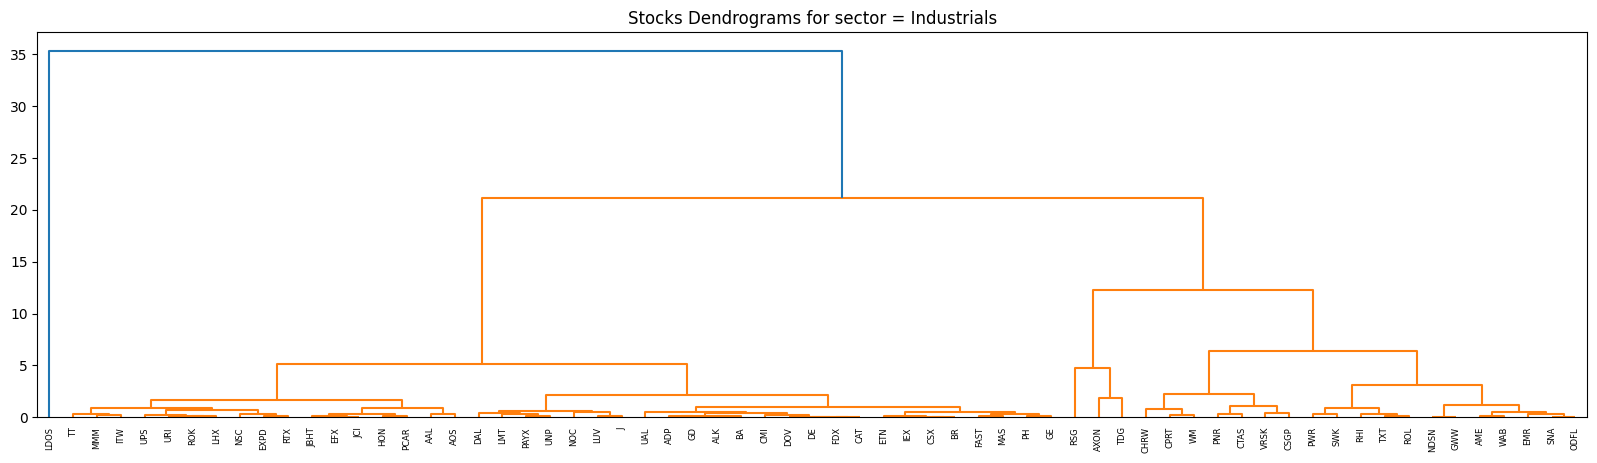

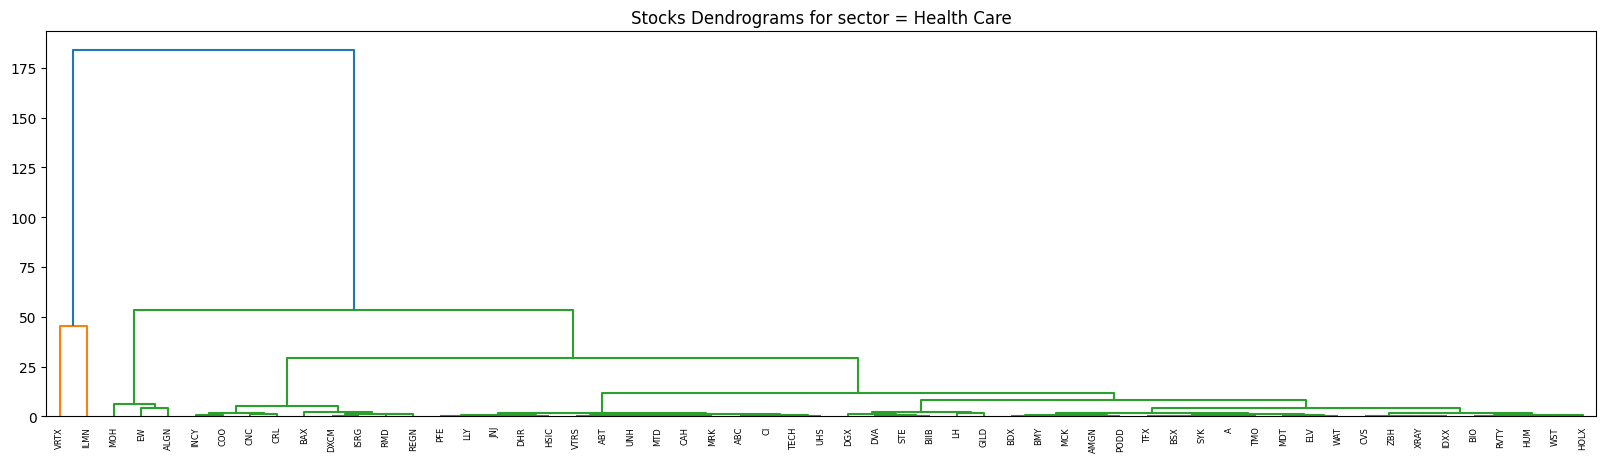

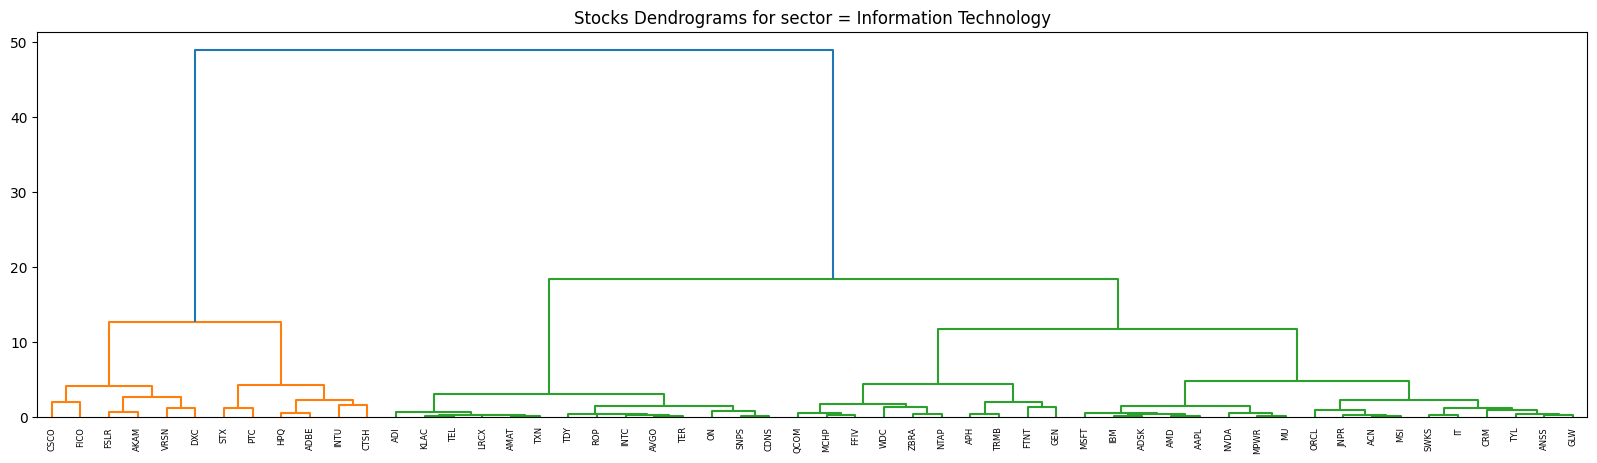

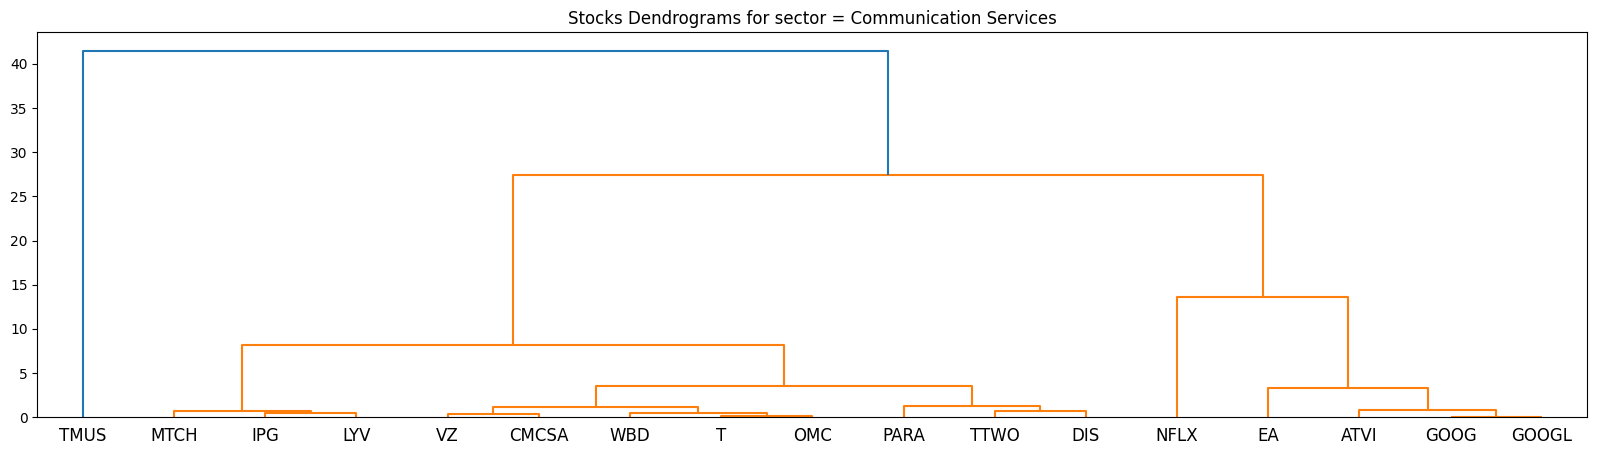

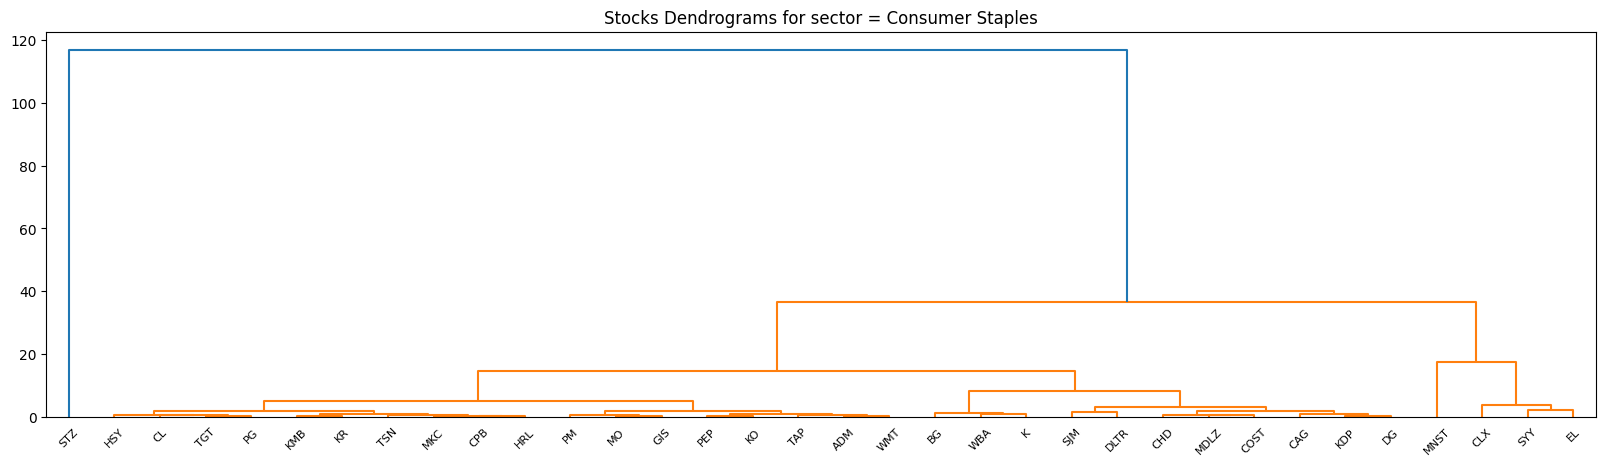

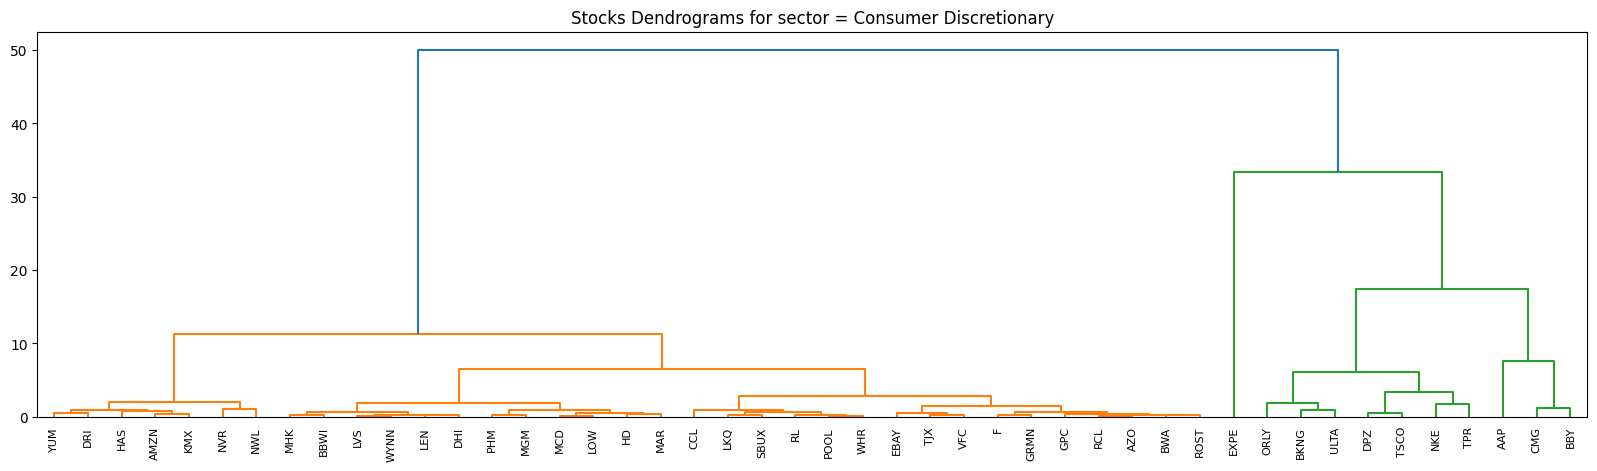

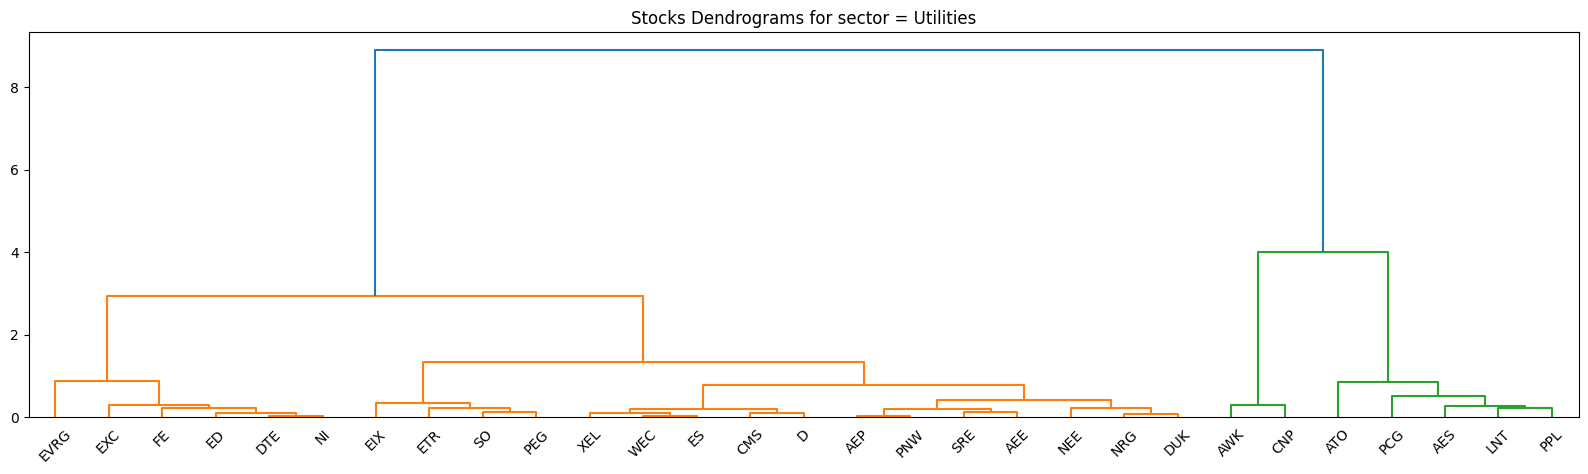

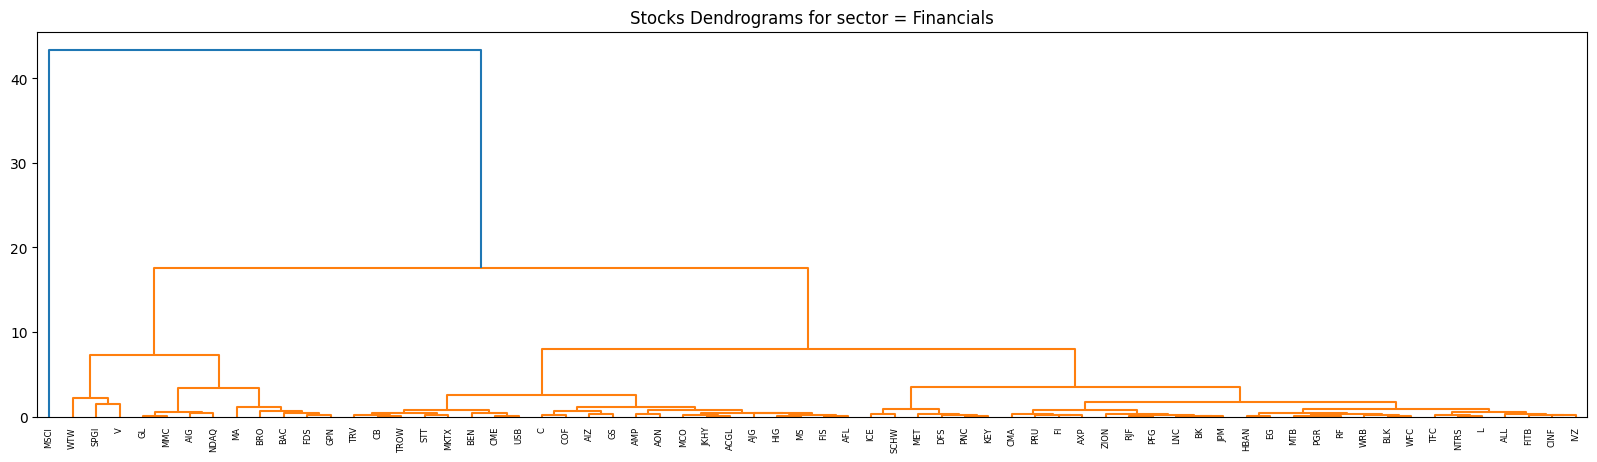

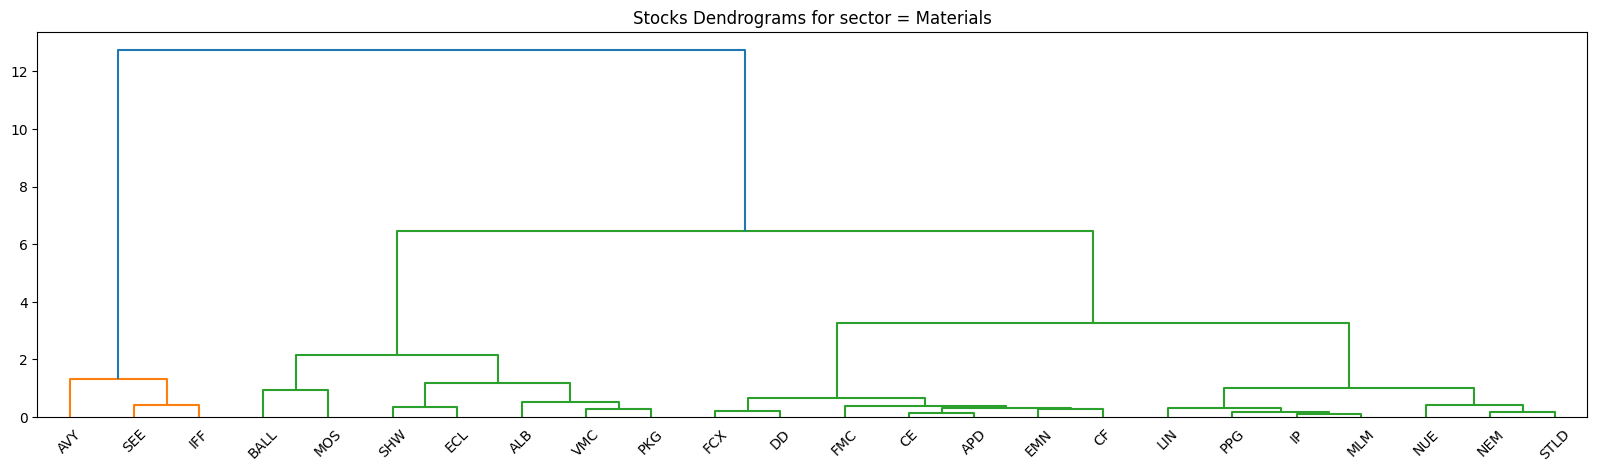

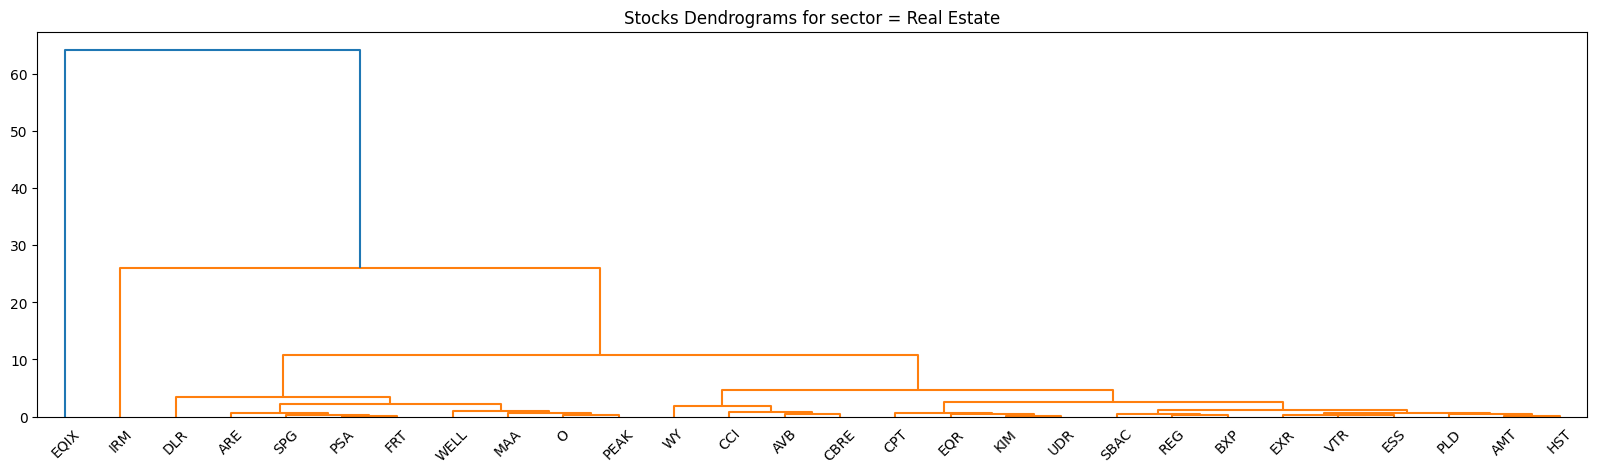

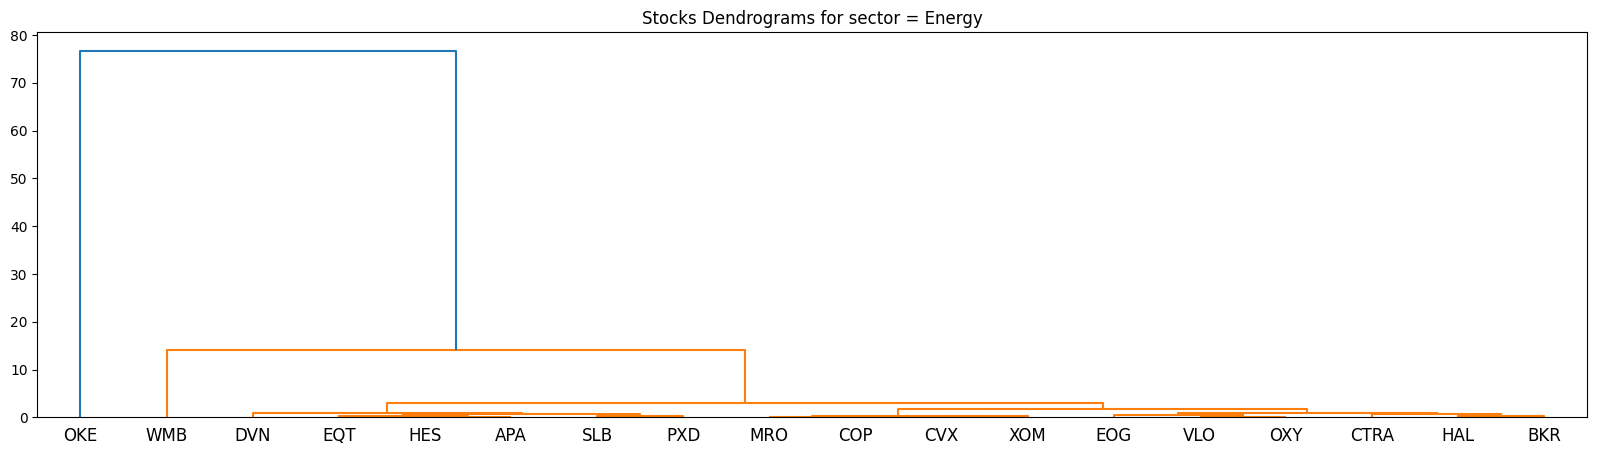

Total number of pairs to check: 8759.0


In [63]:
Z_sec = {}

for sector in sectors:
    #Calulate linkage
    Z_sec[sector] = linkage(df_aggs['train'][sector], method='ward')

total_pairs = 0
num_clusters_dend = {}

for sector in sectors:
    plt.figure(figsize=(20,5))
    plt.title(f"Stocks Dendrograms for sector = {sector}")
    
    dend = dendrogram(Z_sec[sector],labels = df_aggs['train'][sector].index)
    counts = Counter(dend['leaves_color_list'])

    num_clusters_dend[sector] = len(counts)
    
    for x in counts.values():
        total_pairs += x*(x-1)*1/2.
    plt.show()
    
print(f'Total number of pairs to check: {total_pairs}')

### Affinity

In [65]:
clust_labels_ap = {}
tot_pairs = 0

for sector in sectors:
    ap = AffinityPropagation()
    ap.fit(df_aggs['train'][sector])
    clust_labels_ap[sector] = ap.predict(df_aggs['train'][sector])
    
    for x in Counter(clust_labels_ap[sector]).values():
        tot_pairs += x*(x-1)*.5

print(f'Total number of pairs to check: {tot_pairs}')

tot_pairs=0
for x in Counter(clust_labels_ap['Health Care']).values():
        tot_pairs += x*(x-1)*.5

Total number of pairs to check: 2209.0


### Optics

In [76]:
optics_labels = {}
sector_counts = {}

for sector in sectors:
    
    optics_labels[sector] = OPTICS().fit_predict(df_aggs['train'][sector])
    sector_counts[sector] = 0
    
    counts = Counter(optics_labels[sector])
    for label, count in counts.items():
        if label == -1:
            continue
        else:
            sector_counts[sector] += count*(count-1)*.5

In [77]:
np.sum(list(sector_counts.values()))

1504.0

# Pair Trading

In [237]:
clust_labels_ap = {}
tot_pairs = 0

for sector in sectors:
    ap = AffinityPropagation()
    ap.fit(df_aggs['train'][sector])
    clust_labels_ap[sector] = ap.predict(df_aggs['train'][sector])
    
    for x in Counter(clust_labels_ap[sector]).values():
        tot_pairs += x*(x-1)*.5

print(f'Total number of pairs to check: {tot_pairs}')

Total number of pairs to check: 1778.0


In [242]:
from collections import defaultdict

In [265]:
sector_pairs={}
for sector in sectors:
    sector_pairs[sector] = defaultdict(list)
    for ticker,label in zip(df_aggs['train'][sector].index,clust_labels_ap[sector]):
        sector_pairs[sector][label].append(ticker)
    
    for label in clust_labels_ap[sector]:
        if len(sector_pairs[sector][label])<=1:
            del sector_pairs[sector][label]

In [266]:
import itertools

In [274]:
clust_labels_ap[sector]

array([1, 0, 2, 0, 0, 2, 2, 1, 2, 1, 0, 0, 0, 1, 2, 1, 0, 0, 1, 3, 2, 4,
       0])

In [275]:
ct=0
for sector in sectors:
    for label in set(clust_labels_ap[sector]):
        n = len(sector_pairs[sector][label])
        ct+=n*(n-1)*.5
print(ct)

1778.0


In [320]:
ct_dict = {}
for sector in sectors:
    ct=0
    for label in set(clust_labels_ap[sector]):
        n = len(sector_pairs[sector][label])
        ct+=n*(n-1)*.5
    ct_dict[sector] = ct
print(ct_dict)

{'Industrials': 268.0, 'Health Care': 314.0, 'Information Technology': 328.0, 'Communication Services': 37.0, 'Consumer Staples': 101.0, 'Consumer Discretionary': 177.0, 'Utilities': 99.0, 'Financials': 261.0, 'Materials': 56.0, 'Real Estate': 71.0, 'Energy': 66.0}


In [284]:
from tqdm import tqdm

In [365]:
final_pairs = []

for sector in sectors:
    print(sector)
    for label in tqdm(set(clust_labels_ap[sector])):
        pairs_test =  list(itertools.combinations(sector_pairs[sector][label],2))

        for pair in pairs_test:
            stock_1, stock_2 = pair
            result = coint(SP_data[stock_1],SP_data[stock_2])
            score = result[0]
            pvalue = result[1]

            if pvalue <= 0.01:
                final_pairs.append(pair)
print(final_pairs)

Industrials


100%|██████████████████████████████████████████████████████████████████████████████| 13/13 [00:17<00:00,  1.36s/it]


Health Care


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.89s/it]


Information Technology


100%|██████████████████████████████████████████████████████████████████████████████| 11/11 [00:19<00:00,  1.76s/it]


Communication Services


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.58it/s]


Consumer Staples


100%|████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.10s/it]


Consumer Discretionary


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.13s/it]


Utilities


100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.04it/s]


Financials


100%|██████████████████████████████████████████████████████████████████████████████| 11/11 [00:15<00:00,  1.42s/it]


Materials


100%|████████████████████████████████████████████████████████████████████████████████| 7/7 [00:03<00:00,  2.08it/s]


Real Estate


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.90it/s]


Energy


100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.31it/s]

[('LMT', 'NOC'), ('LMT', 'BR'), ('VRSK', 'PAYX'), ('EXPD', 'HON'), ('EXPD', 'WM'), ('EXPD', 'ADP'), ('WM', 'ADP'), ('TDG', 'MAS'), ('ILMN', 'VRTX'), ('BAX', 'A'), ('TMO', 'WAT'), ('TMO', 'SYK'), ('LH', 'BDX'), ('CAH', 'CVS'), ('INTU', 'APH'), ('ROP', 'ANSS'), ('CDW', 'ADBE'), ('ADBE', 'CDNS'), ('F', 'TJX'), ('EXPE', 'HAS'), ('CMS', 'ED'), ('ES', 'ED'), ('STT', 'C'), ('MET', 'COF'), ('COF', 'GS'), ('RF', 'CMA'), ('RF', 'FITB'), ('RF', 'ZION'), ('HBAN', 'SCHW'), ('FITB', 'ZION'), ('DD', 'CE'), ('CCI', 'CPT')]


In [370]:
!pip install hurst --quiet
from hurst import compute_Hc

In [368]:
SP_data['LMT']/SP_data['NOC']

Date
2014-01-02    1.172209
2014-01-03    1.176517
2014-01-06    1.168014
2014-01-07    1.179261
2014-01-08    1.171432
                ...   
2017-12-22    1.002691
2017-12-26    1.004006
2017-12-27    0.999307
2017-12-28    1.000667
2017-12-29    1.001889
Length: 1007, dtype: float64

In [372]:
compute_Hc((SP_data['LMT']/SP_data['NOC']), kind='price', simplified=True)[0]

0.5363501098476828

In [379]:
pairs_hurst = {}

for pair in final_pairs:
    S1, S2 = pair
    
    H_exp = compute_Hc((SP_data[S1]/SP_data[S2]), kind='price', simplified=True)[0]
    if H_exp<.5:
        pairs_hurst[pair] = H_exp

In [390]:
pairs_hf = []

for pair in pairs_hurst.keys():
    
    S1, S2 = pair
    z_array = (SP_data[S1]/SP_data[S2])
    
    z_lag = np.roll(z_array,1)
    z_lag[0] = 0
    z_ret = z_array - z_lag
    z_ret[0] = 0

    #adds intercept terms to X variable for regression
    z_lag2 = sm.add_constant(z_lag)

    model = sm.OLS(z_ret,z_lag2)
    res = model.fit()

    halflife = -np.log(2) / res.params[1]
    
    if 1 < halflife < 100:
        pairs_hf.append(pair)

In [409]:
pair_pt3 = []

for pair in pairs_hf:
    ct=0
    S1, S2 = pair
    ratio = (SP_data[S1]/SP_data[S2])
    
    ratio = ratio - ratio.mean()
    length = ratio.shape[0]
    
    for i in range(1,length):
        if ratio[i]*ratio[i-1]<0:
            ct+=1
    
    if ct>12*length/252:
        pair_pt3.append(pair)

In [411]:
len(pair_pt3)

18

In [412]:
len(final_pairs)

32